In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-12-23 19:46:00.934954: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-23 19:46:14.311406: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-23 19:46:14.331196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-12-23 19:46:14.331264: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-23 19:46:14.336221: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-23 19:46:14.339723: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 769)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


In [5]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)

#t_star = t_star[-3:-1]
#data = data[..., -3:-1]
T = t_star.shape[0]    

L = simulation.L[0]
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

In [6]:
c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

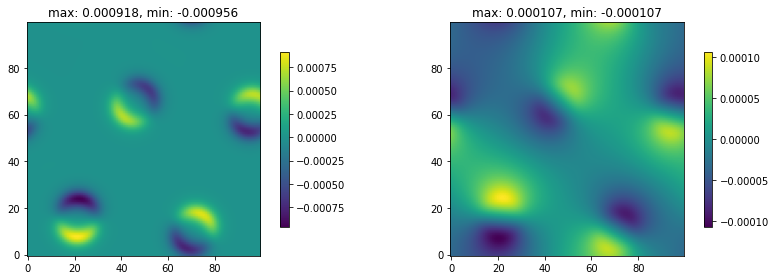

In [7]:
index = -1
_ = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(f"max: {np.max(c_t[0,:,:, index]):.6f}, min: {np.min(c_t[0,:,:, index]):.6f}")
plt.imshow(c_t[0,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.title(f"max: {np.max(c_t[1,:,:, index]):.6f}, min: {np.min(c_t[1,:,:, index]):.6f}")
plt.imshow(c_t[1,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.tight_layout()
plt.show()

In [8]:
data.shape

(2, 100, 100, 769)

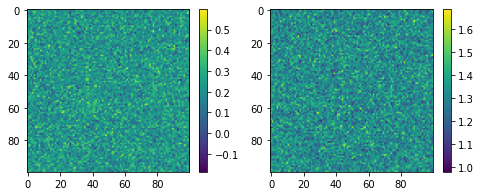

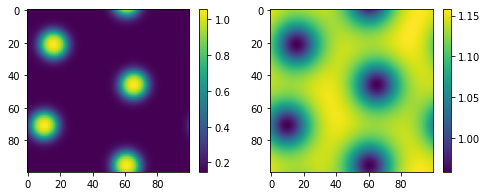

In [9]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

## Note: We use a prefactor to make the amplitude of u, v, u_xx, u_yy, u_t, v_xx, v_yy and v_t more or less in the same order of magnitude. And later, we do the inveres in solving the PDE. It is important for converging to the observed value.

In [10]:
# u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t
outputs_correction_fact = [1, 1, .25, .25, 1000, 2.5, 2.5, 10000]
xx_factors = [.25, 2.5]
yy_factors = [.25, 2.5]
t_factors = [1000, 10000]

dxdy = x_size*y_size/L**2
#c_xx =  np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
c_xx =  np.array([[xx_factors[c] * dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
#c_yy = np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
c_yy = np.array([[yy_factors[c] * dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

#c_t = np.array([[data[c, ..., t] -  data[c, ..., t-1] if t > 0 else data[c, ..., t] -  pre_data[c, ..., 0]
c_t = np.array([[t_factors[c] * (data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [11]:
dxdy = x_size*y_size/L**2
#diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
diff_Y = np.array([[xx_factors[c] * dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [12]:
T

769

In [13]:
c_t.shape

(2, 100, 100, 768)

In [14]:
t_star = t_star[-2:]
data = data[..., -2:]
c_xx = c_xx[..., -2:]
c_yy = c_yy[..., -2:]
c_t = c_t[..., -2:]
diff_Y = diff_Y[..., -2:]
T = t_star.shape[0]  

In [15]:
T

2

In [16]:
data.shape

(2, 100, 100, 2)

In [17]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
#indices_sub = indices_all[:, 30:65, 50:85]
indices_sub = indices_all[:, 30:65:10, 50:85:10]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output']#np.vstack([dataset['obs_output'][first_s],
#                          #dataset['obs_output'][second_s]])

# diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
#                          #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])
obs_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)
# obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs#dataset['pde']
# der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
# obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)

# pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

#diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [18]:
relative_mean_denominators = np.concatenate([np.mean(obs_outputs**2, axis=0),
                                             np.mean(der_u_outputs**2, axis=0),
                                             np.mean(der_v_outputs**2, axis=0), 
                                             [1.0, 1.0]])

In [19]:
obs_X.shape

(32, 11)

In [20]:
c_xx.shape

(2, 100, 100, 2)

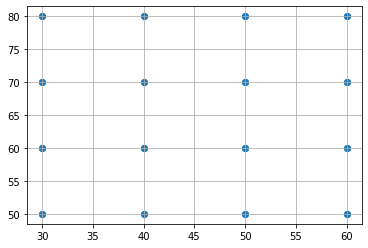

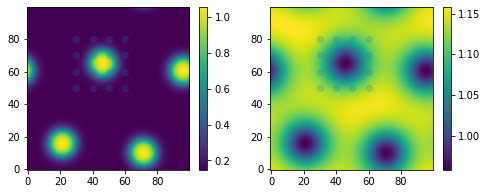

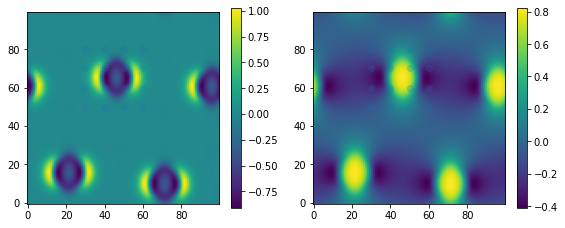

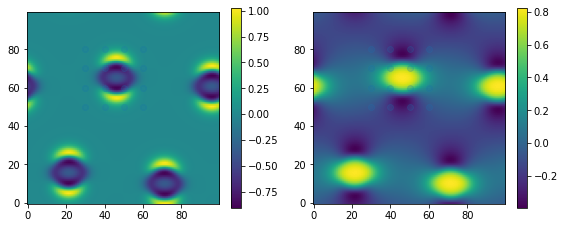

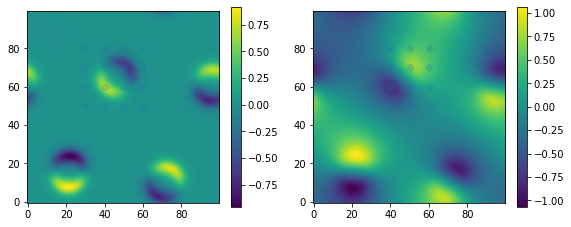

In [21]:
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is cnahging in the outer arrays. So, we must transpose them on
##                ploting time
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(data[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_xx[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_xx[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_yy[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_yy[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_t[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_t[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

In [22]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)

# ds_der = TINN_Dataset(tf.float32, der_X)
# ds_der_1 = TINN_Dataset(tf.float32, obs_X, der_X_1)
# ds_test = TINN_Dataset(tf.float32, obs_test)
# ds_obs_der = TINN_Dataset(tf.float32, obs_der_X)
# ds = TINN_Dataset(tf.float32, obs_der_X, pde_X)


#ds_obs = TINN_Dataset(tf.float32, obs_X)
ds_obs = TINN_Dataset(tf.float32, obs_X, pde_X)

In [23]:
ds_obs.sizes

array([32, 32])

In [24]:
#layers = [3, 1024, 1024, 1024, 8]
#layers = [3, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
layers = [3, 32, 32, 32, 32, 8]

pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard_output_as_Der(
                    dtype = pinnKM.dtype,
                    #D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
                    D_u=PDE_Parameter("D_u", Parameter_Type.VARIABLE, 1.0, dtype=pinnKM.dtype),
                    #D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT,  simulation.Ds[1], dtype=pinnKM.dtype),
                    D_v=PDE_Parameter("D_v", Parameter_Type.VARIABLE,  1.0, dtype=pinnKM.dtype),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, simulation.parameters["kappa_u"] ,dtype=pinnKM.dtype),
                    mu_u=PDE_Parameter("mu_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #mu_u=PDE_Parameter("mu_u", Parameter_Type.CONSTANT, simulation.parameters["mu_u"],dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, simulation.parameters["rho_u"],dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, simulation.parameters["rho_v"],dtype=pinnKM.dtype),                    
                    sigma_u=PDE_Parameter("sigma_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_u=PDE_Parameter("sigma_u", Parameter_Type.CONSTANT, simulation.parameters["sigma_u"],dtype=pinnKM.dtype),
                    sigma_v=PDE_Parameter("sigma_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #sigma_v=PDE_Parameter("sigma_v", Parameter_Type.CONSTANT, simulation.parameters["sigma_v"],dtype=pinnKM.dtype),

                    #                    dtype=pinnKM.dtype),
    outputs_correction_fact = [1, 1, 4, 4, 1/1000, 0.4, 0.4, 1/10000],
    regularise=False
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
#obs_loss = Observation_Loss(regularise=True, input_dim=2)
obs_loss = Observation_Loss(layers=layers, 
                           residual_ret_names=("u", "v", "u_xx", "u_yy", "u_t", "v_xx", "v_yy", "v_t"))
#pbc_loss = Periodic_Boundary_Condition(regularise=True)
#diff_loss_point = Diffusion_point_Loss(
#                            Ds = simulation.Ds,
#                            #input_dim =2,
#                            dtype = pinnKM.dtype)
#der_loss = All_Derivatives_Loss(dtype = pinnKM.dtype,
                            #Ds = simulation.Ds,
#                           )
#obs_der_loss = Observation_And_Derivatives_Loss(dtype = pinnKM.dtype,
#                            Ds = simulation.Ds,
#                           )
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])
#obs_X, pde_X)
modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  #losses= [obs_der_loss],#, pde_resKM],
                  #losses= [der_loss, obs_loss, pde_resKM], 
                  losses= [obs_loss, pde_resKM],
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [25]:
results_KM = modelKM.train(epochs = 3000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 9e-7,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=relative_mean_denominators)
modelKM.optimizer.lr.assign(1e-4)
results_KM2 = modelKM.train(epochs = 500000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 9e-7,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=relative_mean_denominators)


Start of epoch 0


2022-12-23 19:49:05.132573: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-23 19:49:05.795913: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


total loss: 13.682000875473, total regularised loss: 4.521232604980
Observation_Loss -> 
(1)  u: 2.582215070724 (2)  v: 1.120501160622 (3)  u_xx: 1.115163803101 
(4)  u_yy: 1.099638938904 (5)  u_t: 1.262719988823 (6)  v_xx: 2.173345804214 
(7)  v_yy: 1.088608264923 (8)  v_t: 1.096448183060 
Loss_Koch_Meinhard -> 
(9)  res u: 1.156327128410 (10)  res v: 0.987032771111 
D_u: 0.99950 D_v: 1.00050 sigma_u: 0.99950 sigma_v: 0.99950 
mu_u: 1.00050 rho_u: 1.00050 rho_v: 1.00050 kappa_u: 0.99950 

Time taken: 2.73s

Start of epoch 1000
total loss: 6.068246033043, total regularised loss: 0.602472066879
Observation_Loss -> 
(1)  u: 0.898685991764 (2)  v: 0.006974347867 (3)  u_xx: 0.882304430008 
(4)  u_yy: 0.863422036171 (5)  u_t: 0.919955074787 (6)  v_xx: 1.051048040390 
(7)  v_yy: 1.053194642067 (8)  v_t: 0.355402708054 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000095327930 (10)  res v: 0.037163443863 
D_u: 0.98934 D_v: 1.29156 sigma_u: 0.99280 sigma_v: 0.67439 
mu_u: 0.94995 rho_u: 1.15215 rho_v:


Start of epoch 12000
total loss: 0.002367337234, total regularised loss: 0.000566952745
Observation_Loss -> 
(1)  u: 0.000057795085 (2)  v: 0.000004417631 (3)  u_xx: 0.000758545124 
(4)  u_yy: 0.000673154369 (5)  u_t: 0.000003056583 (6)  v_xx: 0.000243582428 
(7)  v_yy: 0.000236060485 (8)  v_t: 0.000001079520 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000340152445 (10)  res v: 0.000049493599 
D_u: 0.10444 D_v: 1.60328 sigma_u: 0.02586 sigma_v: 0.14384 
mu_u: 0.82986 rho_u: 2.39471 rho_v: 1.81947 kappa_u: 0.30901 

Time taken: 17.43s

Start of epoch 13000
total loss: 0.001276826079, total regularised loss: 0.000364451611
Observation_Loss -> 
(1)  u: 0.000071405862 (2)  v: 0.000003375519 (3)  u_xx: 0.000340749859 
(4)  u_yy: 0.000302705943 (5)  u_t: 0.000001874440 (6)  v_xx: 0.000145518556 
(7)  v_yy: 0.000140012751 (8)  v_t: 0.000000680477 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000239753397 (10)  res v: 0.000030749296 
D_u: 0.08285 D_v: 1.56101 sigma_u: 0.04660 sigma_v: 0.14207 
mu_u: 0.8971


Start of epoch 28000
total loss: 0.000037435743, total regularised loss: 0.000003023573
Observation_Loss -> 
(1)  u: 0.000002229435 (2)  v: 0.000000066389 (3)  u_xx: 0.000002150578 
(4)  u_yy: 0.000002360090 (5)  u_t: 0.000021935950 (6)  v_xx: 0.000002267174 
(7)  v_yy: 0.000001070070 (8)  v_t: 0.000005254733 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000060787 (10)  res v: 0.000000040537 
D_u: 0.01116 D_v: 1.32339 sigma_u: 0.10782 sigma_v: 0.13203 
mu_u: 1.07771 rho_u: 2.09422 rho_v: 1.97240 kappa_u: 0.98265 

Time taken: 17.41s

Start of epoch 29000
total loss: 0.000004519476, total regularised loss: 0.000000460095
Observation_Loss -> 
(1)  u: 0.000000235052 (2)  v: 0.000000040693 (3)  u_xx: 0.000000813132 
(4)  u_yy: 0.000000729262 (5)  u_t: 0.000001281329 (6)  v_xx: 0.000000428234 
(7)  v_yy: 0.000000640177 (8)  v_t: 0.000000306021 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000015390 (10)  res v: 0.000000030186 
D_u: 0.01103 D_v: 1.32153 sigma_u: 0.10773 sigma_v: 0.13193 
mu_u: 1.0770


Start of epoch 44000
total loss: 0.000005505071, total regularised loss: 0.000000588904
Observation_Loss -> 
(1)  u: 0.000000464735 (2)  v: 0.000000046950 (3)  u_xx: 0.000001025232 
(4)  u_yy: 0.000000994839 (5)  u_t: 0.000001515072 (6)  v_xx: 0.000000362860 
(7)  v_yy: 0.000000736875 (8)  v_t: 0.000000275386 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000022292 (10)  res v: 0.000000060831 
D_u: 0.01074 D_v: 1.31673 sigma_u: 0.10751 sigma_v: 0.13166 
mu_u: 1.07502 rho_u: 2.09582 rho_v: 1.97474 kappa_u: 0.99948 

Time taken: 17.07s

Start of epoch 45000
total loss: 0.000006193887, total regularised loss: 0.000000988884
Observation_Loss -> 
(1)  u: 0.000000319255 (2)  v: 0.000000102905 (3)  u_xx: 0.000000741333 
(4)  u_yy: 0.000000641587 (5)  u_t: 0.000000775529 (6)  v_xx: 0.000002225834 
(7)  v_yy: 0.000000831452 (8)  v_t: 0.000000184265 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000035893 (10)  res v: 0.000000335833 
D_u: 0.01075 D_v: 1.31669 sigma_u: 0.10751 sigma_v: 0.13167 
mu_u: 1.0750


Start of epoch 60000
total loss: 0.000001863740, total regularised loss: 0.000000187430
Observation_Loss -> 
(1)  u: 0.000000056483 (2)  v: 0.000000019156 (3)  u_xx: 0.000000443357 
(4)  u_yy: 0.000000441752 (5)  u_t: 0.000000426719 (6)  v_xx: 0.000000156025 
(7)  v_yy: 0.000000199384 (8)  v_t: 0.000000107450 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000005571 (10)  res v: 0.000000007843 
D_u: 0.01074 D_v: 1.31602 sigma_u: 0.10747 sigma_v: 0.13159 
mu_u: 1.07458 rho_u: 2.09498 rho_v: 1.97371 kappa_u: 0.99955 

Time taken: 17.38s

Start of epoch 61000
total loss: 0.000001810091, total regularised loss: 0.000000180114
Observation_Loss -> 
(1)  u: 0.000000047724 (2)  v: 0.000000018817 (3)  u_xx: 0.000000439764 
(4)  u_yy: 0.000000431792 (5)  u_t: 0.000000427962 (6)  v_xx: 0.000000144371 
(7)  v_yy: 0.000000188126 (8)  v_t: 0.000000099569 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000005133 (10)  res v: 0.000000006833 
D_u: 0.01074 D_v: 1.31598 sigma_u: 0.10747 sigma_v: 0.13159 
mu_u: 1.0745


Start of epoch 76000
total loss: 0.000004073791, total regularised loss: 0.000000410775
Observation_Loss -> 
(1)  u: 0.000000039950 (2)  v: 0.000000017665 (3)  u_xx: 0.000000697440 
(4)  u_yy: 0.000000526835 (5)  u_t: 0.000001018973 (6)  v_xx: 0.000000644925 
(7)  v_yy: 0.000000791026 (8)  v_t: 0.000000272965 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000004579 (10)  res v: 0.000000059432 
D_u: 0.01073 D_v: 1.31535 sigma_u: 0.10743 sigma_v: 0.13153 
mu_u: 1.07418 rho_u: 2.09421 rho_v: 1.97272 kappa_u: 0.99957 

Time taken: 17.51s

Start of epoch 77000
total loss: 0.000001654313, total regularised loss: 0.000000170071
Observation_Loss -> 
(1)  u: 0.000000064249 (2)  v: 0.000000015846 (3)  u_xx: 0.000000372999 
(4)  u_yy: 0.000000394625 (5)  u_t: 0.000000421357 (6)  v_xx: 0.000000116040 
(7)  v_yy: 0.000000149707 (8)  v_t: 0.000000101754 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000004908 (10)  res v: 0.000000012829 
D_u: 0.01073 D_v: 1.31532 sigma_u: 0.10743 sigma_v: 0.13152 
mu_u: 1.0741


Start of epoch 92000
total loss: 0.000004888675, total regularised loss: 0.000000438766
Observation_Loss -> 
(1)  u: 0.000000319288 (2)  v: 0.000000017941 (3)  u_xx: 0.000000667221 
(4)  u_yy: 0.000000737553 (5)  u_t: 0.000001833190 (6)  v_xx: 0.000000329391 
(7)  v_yy: 0.000000439503 (8)  v_t: 0.000000526698 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000010787 (10)  res v: 0.000000007105 
D_u: 0.01073 D_v: 1.31471 sigma_u: 0.10739 sigma_v: 0.13146 
mu_u: 1.07381 rho_u: 2.09349 rho_v: 1.97176 kappa_u: 0.99958 

Time taken: 18.77s

Start of epoch 93000
total loss: 0.000014293762, total regularised loss: 0.000001216419
Observation_Loss -> 
(1)  u: 0.000001029568 (2)  v: 0.000000014094 (3)  u_xx: 0.000000533050 
(4)  u_yy: 0.000000713791 (5)  u_t: 0.000009485925 (6)  v_xx: 0.000000207199 
(7)  v_yy: 0.000000192850 (8)  v_t: 0.000001962663 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000026030 (10)  res v: 0.000000128592 
D_u: 0.01073 D_v: 1.31468 sigma_u: 0.10740 sigma_v: 0.13147 
mu_u: 1.0737


Start of epoch 108000
total loss: 0.000001269428, total regularised loss: 0.000000124438
Observation_Loss -> 
(1)  u: 0.000000029947 (2)  v: 0.000000012300 (3)  u_xx: 0.000000316999 
(4)  u_yy: 0.000000341472 (5)  u_t: 0.000000292965 (6)  v_xx: 0.000000070575 
(7)  v_yy: 0.000000133335 (8)  v_t: 0.000000064250 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000003063 (10)  res v: 0.000000004524 
D_u: 0.01073 D_v: 1.31407 sigma_u: 0.10736 sigma_v: 0.13140 
mu_u: 1.07346 rho_u: 2.09281 rho_v: 1.97080 kappa_u: 0.99958 

Time taken: 18.07s

Start of epoch 109000
total loss: 0.000001266744, total regularised loss: 0.000000123778
Observation_Loss -> 
(1)  u: 0.000000025522 (2)  v: 0.000000012311 (3)  u_xx: 0.000000291952 
(4)  u_yy: 0.000000328220 (5)  u_t: 0.000000332390 (6)  v_xx: 0.000000074424 
(7)  v_yy: 0.000000108510 (8)  v_t: 0.000000085805 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000003163 (10)  res v: 0.000000004447 
D_u: 0.01073 D_v: 1.31403 sigma_u: 0.10736 sigma_v: 0.13140 
mu_u: 1.07


Start of epoch 124000
total loss: 0.000003071350, total regularised loss: 0.000000471031
Observation_Loss -> 
(1)  u: 0.000000367534 (2)  v: 0.000000035716 (3)  u_xx: 0.000000330895 
(4)  u_yy: 0.000000431499 (5)  u_t: 0.000000700236 (6)  v_xx: 0.000000648905 
(7)  v_yy: 0.000000259633 (8)  v_t: 0.000000116980 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000018536 (10)  res v: 0.000000161416 
D_u: 0.01072 D_v: 1.31344 sigma_u: 0.10732 sigma_v: 0.13133 
mu_u: 1.07312 rho_u: 2.09217 rho_v: 1.96987 kappa_u: 0.99958 

Time taken: 16.00s

Start of epoch 125000
total loss: 0.000065870464, total regularised loss: 0.000005226857
Observation_Loss -> 
(1)  u: 0.000002391791 (2)  v: 0.000000029807 (3)  u_xx: 0.000002443664 
(4)  u_yy: 0.000002024229 (5)  u_t: 0.000043502387 (6)  v_xx: 0.000002006527 
(7)  v_yy: 0.000004303775 (8)  v_t: 0.000008683605 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000052657 (10)  res v: 0.000000432021 
D_u: 0.01073 D_v: 1.31341 sigma_u: 0.10733 sigma_v: 0.13134 
mu_u: 1.07


Start of epoch 140000
total loss: 0.000002636772, total regularised loss: 0.000000225551
Observation_Loss -> 
(1)  u: 0.000000092134 (2)  v: 0.000000011477 (3)  u_xx: 0.000000323777 
(4)  u_yy: 0.000000370289 (5)  u_t: 0.000001218670 (6)  v_xx: 0.000000183378 
(7)  v_yy: 0.000000134329 (8)  v_t: 0.000000294152 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000004244 (10)  res v: 0.000000004321 
D_u: 0.01072 D_v: 1.31282 sigma_u: 0.10730 sigma_v: 0.13127 
mu_u: 1.07281 rho_u: 2.09156 rho_v: 1.96894 kappa_u: 0.99959 

Time taken: 18.34s

Start of epoch 141000
total loss: 0.000010718890, total regularised loss: 0.000000870099
Observation_Loss -> 
(1)  u: 0.000000500575 (2)  v: 0.000000014695 (3)  u_xx: 0.000000419504 
(4)  u_yy: 0.000000496584 (5)  u_t: 0.000007090600 (6)  v_xx: 0.000000237358 
(7)  v_yy: 0.000000306142 (8)  v_t: 0.000001579757 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000012244 (10)  res v: 0.000000061432 
D_u: 0.01072 D_v: 1.31278 sigma_u: 0.10729 sigma_v: 0.13127 
mu_u: 1.07

In [69]:
modelKM.optimizer.lr.assign(5e-5)
results_KM3 = modelKM.train(epochs = 500000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 9e-8,
                          sample_losses = True,              
                          sample_regularisations = False,
                          regularise=False,
                          regularise_interval=1,
                          relative_mean_denominators=relative_mean_denominators)


Start of epoch 0
total loss: 0.000001827482, total regularised loss: 0.000000181656
Observation_Loss -> 
(1)  u: 0.000000025513 (2)  v: 0.000000019257 (3)  u_xx: 0.000000474033 
(4)  u_yy: 0.000000552804 (5)  u_t: 0.000000378627 (6)  v_xx: 0.000000095537 
(7)  v_yy: 0.000000175344 (8)  v_t: 0.000000095396 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000004200 (10)  res v: 0.000000006770 
D_u: 0.01072 D_v: 1.31256 sigma_u: 0.10728 sigma_v: 0.13125 
mu_u: 1.07268 rho_u: 2.09130 rho_v: 1.96855 kappa_u: 0.99959 

Time taken: 0.07s

Start of epoch 1000
total loss: 0.000000892115, total regularised loss: 0.000000089073
Observation_Loss -> 
(1)  u: 0.000000012336 (2)  v: 0.000000009551 (3)  u_xx: 0.000000235668 
(4)  u_yy: 0.000000275069 (5)  u_t: 0.000000176990 (6)  v_xx: 0.000000045462 
(7)  v_yy: 0.000000086681 (8)  v_t: 0.000000044947 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000002071 (10)  res v: 0.000000003340 
D_u: 0.01072 D_v: 1.31257 sigma_u: 0.10728 sigma_v: 0.13125 
mu_u: 1.07268 rho_


Start of epoch 16000
total loss: 0.000001057793, total regularised loss: 0.000000103436
Observation_Loss -> 
(1)  u: 0.000000013737 (2)  v: 0.000000010285 (3)  u_xx: 0.000000229975 
(4)  u_yy: 0.000000271545 (5)  u_t: 0.000000282367 (6)  v_xx: 0.000000077877 
(7)  v_yy: 0.000000089687 (8)  v_t: 0.000000075575 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000002209 (10)  res v: 0.000000004535 
D_u: 0.01072 D_v: 1.31243 sigma_u: 0.10727 sigma_v: 0.13123 
mu_u: 1.07256 rho_u: 2.09102 rho_v: 1.96827 kappa_u: 0.99948 

Time taken: 17.35s

Start of epoch 17000
total loss: 0.000001994707, total regularised loss: 0.000000306845
Observation_Loss -> 
(1)  u: 0.000000080102 (2)  v: 0.000000026115 (3)  u_xx: 0.000000274981 
(4)  u_yy: 0.000000285708 (5)  u_t: 0.000000199743 (6)  v_xx: 0.000000647876 
(7)  v_yy: 0.000000318235 (8)  v_t: 0.000000046569 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000008964 (10)  res v: 0.000000106415 
D_u: 0.01073 D_v: 1.31243 sigma_u: 0.10727 sigma_v: 0.13124 
mu_u: 1.0725


Start of epoch 32000
total loss: 0.000000807709, total regularised loss: 0.000000080279
Observation_Loss -> 
(1)  u: 0.000000012763 (2)  v: 0.000000008572 (3)  u_xx: 0.000000210347 
(4)  u_yy: 0.000000248594 (5)  u_t: 0.000000165980 (6)  v_xx: 0.000000038021 
(7)  v_yy: 0.000000077389 (8)  v_t: 0.000000041380 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001645 (10)  res v: 0.000000003017 
D_u: 0.01072 D_v: 1.31224 sigma_u: 0.10725 sigma_v: 0.13121 
mu_u: 1.07242 rho_u: 2.09075 rho_v: 1.96798 kappa_u: 0.99948 

Time taken: 17.61s

Start of epoch 33000
total loss: 0.000000881802, total regularised loss: 0.000000094534
Observation_Loss -> 
(1)  u: 0.000000016361 (2)  v: 0.000000009690 (3)  u_xx: 0.000000211046 
(4)  u_yy: 0.000000255309 (5)  u_t: 0.000000167417 (6)  v_xx: 0.000000070290 
(7)  v_yy: 0.000000093348 (8)  v_t: 0.000000047005 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000002234 (10)  res v: 0.000000009103 
D_u: 0.01072 D_v: 1.31223 sigma_u: 0.10725 sigma_v: 0.13121 
mu_u: 1.0724


Start of epoch 48000
total loss: 0.000004429332, total regularised loss: 0.000000375276
Observation_Loss -> 
(1)  u: 0.000000242139 (2)  v: 0.000000010601 (3)  u_xx: 0.000000500760 
(4)  u_yy: 0.000000535839 (5)  u_t: 0.000001973664 (6)  v_xx: 0.000000334704 
(7)  v_yy: 0.000000317851 (8)  v_t: 0.000000501677 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000007144 (10)  res v: 0.000000004954 
D_u: 0.01072 D_v: 1.31206 sigma_u: 0.10724 sigma_v: 0.13120 
mu_u: 1.07227 rho_u: 2.09046 rho_v: 1.96771 kappa_u: 0.99948 

Time taken: 17.59s

Start of epoch 49000
total loss: 0.000012229776, total regularised loss: 0.000001076677
Observation_Loss -> 
(1)  u: 0.000001011647 (2)  v: 0.000000012035 (3)  u_xx: 0.000000382972 
(4)  u_yy: 0.000000581363 (5)  u_t: 0.000008191083 (6)  v_xx: 0.000000133438 
(7)  v_yy: 0.000000107585 (8)  v_t: 0.000001640875 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000025900 (10)  res v: 0.000000142876 
D_u: 0.01071 D_v: 1.31204 sigma_u: 0.10724 sigma_v: 0.13119 
mu_u: 1.0722


Start of epoch 64000
total loss: 0.000000978093, total regularised loss: 0.000000092817
Observation_Loss -> 
(1)  u: 0.000000028251 (2)  v: 0.000000008409 (3)  u_xx: 0.000000210972 
(4)  u_yy: 0.000000243080 (5)  u_t: 0.000000285252 (6)  v_xx: 0.000000040186 
(7)  v_yy: 0.000000089399 (8)  v_t: 0.000000067940 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001537 (10)  res v: 0.000000003067 
D_u: 0.01072 D_v: 1.31187 sigma_u: 0.10723 sigma_v: 0.13118 
mu_u: 1.07213 rho_u: 2.09019 rho_v: 1.96743 kappa_u: 0.99948 

Time taken: 18.41s

Start of epoch 65000
total loss: 0.000000861993, total regularised loss: 0.000000084824
Observation_Loss -> 
(1)  u: 0.000000015186 (2)  v: 0.000000007703 (3)  u_xx: 0.000000201492 
(4)  u_yy: 0.000000253107 (5)  u_t: 0.000000175737 (6)  v_xx: 0.000000054178 
(7)  v_yy: 0.000000090057 (8)  v_t: 0.000000059957 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001627 (10)  res v: 0.000000002950 
D_u: 0.01072 D_v: 1.31186 sigma_u: 0.10723 sigma_v: 0.13118 
mu_u: 1.0721


Start of epoch 80000
total loss: 0.000000741607, total regularised loss: 0.000000072887
Observation_Loss -> 
(1)  u: 0.000000012751 (2)  v: 0.000000007589 (3)  u_xx: 0.000000183393 
(4)  u_yy: 0.000000220520 (5)  u_t: 0.000000165564 (6)  v_xx: 0.000000035702 
(7)  v_yy: 0.000000070189 (8)  v_t: 0.000000041999 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001295 (10)  res v: 0.000000002605 
D_u: 0.01072 D_v: 1.31170 sigma_u: 0.10721 sigma_v: 0.13116 
mu_u: 1.07201 rho_u: 2.08995 rho_v: 1.96718 kappa_u: 0.99949 

Time taken: 17.35s

Start of epoch 81000
total loss: 0.000000680894, total regularised loss: 0.000000068278
Observation_Loss -> 
(1)  u: 0.000000009510 (2)  v: 0.000000007526 (3)  u_xx: 0.000000179631 
(4)  u_yy: 0.000000217770 (5)  u_t: 0.000000125955 (6)  v_xx: 0.000000034121 
(7)  v_yy: 0.000000066044 (8)  v_t: 0.000000036695 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001208 (10)  res v: 0.000000002435 
D_u: 0.01072 D_v: 1.31169 sigma_u: 0.10721 sigma_v: 0.13116 
mu_u: 1.0720


Start of epoch 96000
total loss: 0.000001352939, total regularised loss: 0.000000121271
Observation_Loss -> 
(1)  u: 0.000000057940 (2)  v: 0.000000007557 (3)  u_xx: 0.000000191842 
(4)  u_yy: 0.000000239495 (5)  u_t: 0.000000591770 (6)  v_xx: 0.000000047464 
(7)  v_yy: 0.000000065018 (8)  v_t: 0.000000144942 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000002114 (10)  res v: 0.000000004796 
D_u: 0.01071 D_v: 1.31152 sigma_u: 0.10720 sigma_v: 0.13114 
mu_u: 1.07188 rho_u: 2.08971 rho_v: 1.96692 kappa_u: 0.99949 

Time taken: 17.18s

Start of epoch 97000
total loss: 0.000000691865, total regularised loss: 0.000000069126
Observation_Loss -> 
(1)  u: 0.000000010449 (2)  v: 0.000000007273 (3)  u_xx: 0.000000174619 
(4)  u_yy: 0.000000212217 (5)  u_t: 0.000000138444 (6)  v_xx: 0.000000035931 
(7)  v_yy: 0.000000068263 (8)  v_t: 0.000000040655 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001164 (10)  res v: 0.000000002849 
D_u: 0.01071 D_v: 1.31151 sigma_u: 0.10720 sigma_v: 0.13114 
mu_u: 1.0718


Start of epoch 112000
total loss: 0.000002183470, total regularised loss: 0.000000189550
Observation_Loss -> 
(1)  u: 0.000000101684 (2)  v: 0.000000007979 (3)  u_xx: 0.000000196927 
(4)  u_yy: 0.000000244981 (5)  u_t: 0.000001211964 (6)  v_xx: 0.000000069272 
(7)  v_yy: 0.000000099971 (8)  v_t: 0.000000231919 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000003510 (10)  res v: 0.000000015263 
D_u: 0.01071 D_v: 1.31135 sigma_u: 0.10719 sigma_v: 0.13113 
mu_u: 1.07176 rho_u: 2.08947 rho_v: 1.96666 kappa_u: 0.99949 

Time taken: 17.30s

Start of epoch 113000
total loss: 0.000000649619, total regularised loss: 0.000000064662
Observation_Loss -> 
(1)  u: 0.000000010149 (2)  v: 0.000000007128 (3)  u_xx: 0.000000166497 
(4)  u_yy: 0.000000201595 (5)  u_t: 0.000000130450 (6)  v_xx: 0.000000032143 
(7)  v_yy: 0.000000060970 (8)  v_t: 0.000000037486 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001019 (10)  res v: 0.000000002181 
D_u: 0.01071 D_v: 1.31134 sigma_u: 0.10719 sigma_v: 0.13113 
mu_u: 1.07


Start of epoch 128000
total loss: 0.000000635890, total regularised loss: 0.000000064200
Observation_Loss -> 
(1)  u: 0.000000009419 (2)  v: 0.000000007455 (3)  u_xx: 0.000000160815 
(4)  u_yy: 0.000000195140 (5)  u_t: 0.000000125842 (6)  v_xx: 0.000000036354 
(7)  v_yy: 0.000000057832 (8)  v_t: 0.000000039698 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001014 (10)  res v: 0.000000002321 
D_u: 0.01071 D_v: 1.31118 sigma_u: 0.10718 sigma_v: 0.13111 
mu_u: 1.07164 rho_u: 2.08922 rho_v: 1.96639 kappa_u: 0.99949 

Time taken: 17.49s

Start of epoch 129000
total loss: 0.000000685510, total regularised loss: 0.000000067908
Observation_Loss -> 
(1)  u: 0.000000012811 (2)  v: 0.000000007473 (3)  u_xx: 0.000000165314 
(4)  u_yy: 0.000000197367 (5)  u_t: 0.000000152431 (6)  v_xx: 0.000000041148 
(7)  v_yy: 0.000000061598 (8)  v_t: 0.000000044113 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001068 (10)  res v: 0.000000002188 
D_u: 0.01071 D_v: 1.31116 sigma_u: 0.10718 sigma_v: 0.13111 
mu_u: 1.07


Start of epoch 144000
total loss: 0.000001117708, total regularised loss: 0.000000100822
Observation_Loss -> 
(1)  u: 0.000000026459 (2)  v: 0.000000008069 (3)  u_xx: 0.000000175150 
(4)  u_yy: 0.000000209952 (5)  u_t: 0.000000432757 (6)  v_xx: 0.000000081117 
(7)  v_yy: 0.000000067553 (8)  v_t: 0.000000112946 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001461 (10)  res v: 0.000000002243 
D_u: 0.01071 D_v: 1.31100 sigma_u: 0.10717 sigma_v: 0.13109 
mu_u: 1.07151 rho_u: 2.08899 rho_v: 1.96614 kappa_u: 0.99949 

Time taken: 17.28s

Start of epoch 145000
total loss: 0.000001215130, total regularised loss: 0.000000111276
Observation_Loss -> 
(1)  u: 0.000000040773 (2)  v: 0.000000007052 (3)  u_xx: 0.000000232107 
(4)  u_yy: 0.000000243310 (5)  u_t: 0.000000358957 (6)  v_xx: 0.000000102106 
(7)  v_yy: 0.000000140321 (8)  v_t: 0.000000085470 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001530 (10)  res v: 0.000000003505 
D_u: 0.01071 D_v: 1.31099 sigma_u: 0.10716 sigma_v: 0.13109 
mu_u: 1.07


Start of epoch 160000
total loss: 0.000000658136, total regularised loss: 0.000000066084
Observation_Loss -> 
(1)  u: 0.000000015848 (2)  v: 0.000000006765 (3)  u_xx: 0.000000163835 
(4)  u_yy: 0.000000200107 (5)  u_t: 0.000000116524 (6)  v_xx: 0.000000038856 
(7)  v_yy: 0.000000072715 (8)  v_t: 0.000000040186 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001076 (10)  res v: 0.000000002225 
D_u: 0.01071 D_v: 1.31083 sigma_u: 0.10715 sigma_v: 0.13107 
mu_u: 1.07139 rho_u: 2.08876 rho_v: 1.96588 kappa_u: 0.99950 

Time taken: 17.28s

Start of epoch 161000
total loss: 0.000000711076, total regularised loss: 0.000000069041
Observation_Loss -> 
(1)  u: 0.000000014735 (2)  v: 0.000000007249 (3)  u_xx: 0.000000157633 
(4)  u_yy: 0.000000186989 (5)  u_t: 0.000000183044 (6)  v_xx: 0.000000048967 
(7)  v_yy: 0.000000060189 (8)  v_t: 0.000000049162 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000937 (10)  res v: 0.000000002170 
D_u: 0.01071 D_v: 1.31082 sigma_u: 0.10715 sigma_v: 0.13107 
mu_u: 1.07


Start of epoch 176000
total loss: 0.000000630760, total regularised loss: 0.000000061917
Observation_Loss -> 
(1)  u: 0.000000016635 (2)  v: 0.000000006727 (3)  u_xx: 0.000000146980 
(4)  u_yy: 0.000000177467 (5)  u_t: 0.000000158509 (6)  v_xx: 0.000000028470 
(7)  v_yy: 0.000000050116 (8)  v_t: 0.000000043016 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000840 (10)  res v: 0.000000002000 
D_u: 0.01071 D_v: 1.31067 sigma_u: 0.10714 sigma_v: 0.13106 
mu_u: 1.07128 rho_u: 2.08853 rho_v: 1.96564 kappa_u: 0.99950 

Time taken: 17.84s

Start of epoch 177000
total loss: 0.000000758792, total regularised loss: 0.000000082776
Observation_Loss -> 
(1)  u: 0.000000024603 (2)  v: 0.000000007418 (3)  u_xx: 0.000000157135 
(4)  u_yy: 0.000000179705 (5)  u_t: 0.000000172445 (6)  v_xx: 0.000000075128 
(7)  v_yy: 0.000000087724 (8)  v_t: 0.000000041873 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001215 (10)  res v: 0.000000011545 
D_u: 0.01071 D_v: 1.31066 sigma_u: 0.10714 sigma_v: 0.13106 
mu_u: 1.07


Start of epoch 192000
total loss: 0.000001024649, total regularised loss: 0.000000096040
Observation_Loss -> 
(1)  u: 0.000000055058 (2)  v: 0.000000006588 (3)  u_xx: 0.000000152127 
(4)  u_yy: 0.000000191111 (5)  u_t: 0.000000428309 (6)  v_xx: 0.000000031649 
(7)  v_yy: 0.000000048987 (8)  v_t: 0.000000103060 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001757 (10)  res v: 0.000000006002 
D_u: 0.01071 D_v: 1.31050 sigma_u: 0.10713 sigma_v: 0.13104 
mu_u: 1.07116 rho_u: 2.08830 rho_v: 1.96538 kappa_u: 0.99950 

Time taken: 17.04s

Start of epoch 193000
total loss: 0.000000840198, total regularised loss: 0.000000082911
Observation_Loss -> 
(1)  u: 0.000000025834 (2)  v: 0.000000006707 (3)  u_xx: 0.000000177483 
(4)  u_yy: 0.000000224069 (5)  u_t: 0.000000168889 (6)  v_xx: 0.000000060149 
(7)  v_yy: 0.000000100354 (8)  v_t: 0.000000072693 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001300 (10)  res v: 0.000000002722 
D_u: 0.01071 D_v: 1.31049 sigma_u: 0.10713 sigma_v: 0.13104 
mu_u: 1.07


Start of epoch 208000
total loss: 0.000001076587, total regularised loss: 0.000000121846
Observation_Loss -> 
(1)  u: 0.000000022711 (2)  v: 0.000000012338 (3)  u_xx: 0.000000169208 
(4)  u_yy: 0.000000201283 (5)  u_t: 0.000000268103 (6)  v_xx: 0.000000211408 
(7)  v_yy: 0.000000092271 (8)  v_t: 0.000000078092 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000002641 (10)  res v: 0.000000018531 
D_u: 0.01071 D_v: 1.31034 sigma_u: 0.10712 sigma_v: 0.13103 
mu_u: 1.07105 rho_u: 2.08808 rho_v: 1.96514 kappa_u: 0.99950 

Time taken: 17.31s

Start of epoch 209000
total loss: 0.000001816706, total regularised loss: 0.000000181747
Observation_Loss -> 
(1)  u: 0.000000170595 (2)  v: 0.000000009084 (3)  u_xx: 0.000000182492 
(4)  u_yy: 0.000000239714 (5)  u_t: 0.000000901432 (6)  v_xx: 0.000000036992 
(7)  v_yy: 0.000000059264 (8)  v_t: 0.000000186921 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000005391 (10)  res v: 0.000000024821 
D_u: 0.01071 D_v: 1.31033 sigma_u: 0.10712 sigma_v: 0.13103 
mu_u: 1.07


Start of epoch 224000
total loss: 0.000001766408, total regularised loss: 0.000000163614
Observation_Loss -> 
(1)  u: 0.000000025450 (2)  v: 0.000000016357 (3)  u_xx: 0.000000169635 
(4)  u_yy: 0.000000198590 (5)  u_t: 0.000000855558 (6)  v_xx: 0.000000165742 
(7)  v_yy: 0.000000070616 (8)  v_t: 0.000000255172 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000002946 (10)  res v: 0.000000006342 
D_u: 0.01071 D_v: 1.31016 sigma_u: 0.10710 sigma_v: 0.13101 
mu_u: 1.07094 rho_u: 2.08787 rho_v: 1.96489 kappa_u: 0.99950 

Time taken: 17.32s

Start of epoch 225000
total loss: 0.000000818904, total regularised loss: 0.000000115158
Observation_Loss -> 
(1)  u: 0.000000041914 (2)  v: 0.000000012290 (3)  u_xx: 0.000000140227 
(4)  u_yy: 0.000000163417 (5)  u_t: 0.000000127051 (6)  v_xx: 0.000000176748 
(7)  v_yy: 0.000000091085 (8)  v_t: 0.000000031835 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000003146 (10)  res v: 0.000000031190 
D_u: 0.01070 D_v: 1.31015 sigma_u: 0.10711 sigma_v: 0.13100 
mu_u: 1.07


Start of epoch 240000
total loss: 0.000000476400, total regularised loss: 0.000000049030
Observation_Loss -> 
(1)  u: 0.000000010146 (2)  v: 0.000000006362 (3)  u_xx: 0.000000126359 
(4)  u_yy: 0.000000153653 (5)  u_t: 0.000000083361 (6)  v_xx: 0.000000025039 
(7)  v_yy: 0.000000040406 (8)  v_t: 0.000000029024 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000582 (10)  res v: 0.000000001466 
D_u: 0.01070 D_v: 1.31001 sigma_u: 0.10709 sigma_v: 0.13099 
mu_u: 1.07082 rho_u: 2.08764 rho_v: 1.96465 kappa_u: 0.99950 

Time taken: 17.32s

Start of epoch 241000
total loss: 0.000000579129, total regularised loss: 0.000000058332
Observation_Loss -> 
(1)  u: 0.000000015218 (2)  v: 0.000000006450 (3)  u_xx: 0.000000141329 
(4)  u_yy: 0.000000165271 (5)  u_t: 0.000000111743 (6)  v_xx: 0.000000040188 
(7)  v_yy: 0.000000059315 (8)  v_t: 0.000000036880 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000748 (10)  res v: 0.000000001987 
D_u: 0.01070 D_v: 1.31000 sigma_u: 0.10709 sigma_v: 0.13099 
mu_u: 1.07


Start of epoch 256000
total loss: 0.000000504839, total regularised loss: 0.000000051981
Observation_Loss -> 
(1)  u: 0.000000014716 (2)  v: 0.000000006308 (3)  u_xx: 0.000000130800 
(4)  u_yy: 0.000000158405 (5)  u_t: 0.000000084988 (6)  v_xx: 0.000000027338 
(7)  v_yy: 0.000000048001 (8)  v_t: 0.000000032025 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000713 (10)  res v: 0.000000001545 
D_u: 0.01070 D_v: 1.30984 sigma_u: 0.10708 sigma_v: 0.13098 
mu_u: 1.07071 rho_u: 2.08742 rho_v: 1.96440 kappa_u: 0.99950 

Time taken: 17.67s

Start of epoch 257000
total loss: 0.000001535099, total regularised loss: 0.000000255802
Observation_Loss -> 
(1)  u: 0.000000078139 (2)  v: 0.000000030797 (3)  u_xx: 0.000000168563 
(4)  u_yy: 0.000000192608 (5)  u_t: 0.000000182853 (6)  v_xx: 0.000000539116 
(7)  v_yy: 0.000000175778 (8)  v_t: 0.000000071645 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000009500 (10)  res v: 0.000000086100 
D_u: 0.01071 D_v: 1.30984 sigma_u: 0.10708 sigma_v: 0.13098 
mu_u: 1.07


Start of epoch 272000
total loss: 0.000002264602, total regularised loss: 0.000000195268
Observation_Loss -> 
(1)  u: 0.000000062817 (2)  v: 0.000000011081 (3)  u_xx: 0.000000211347 
(4)  u_yy: 0.000000238988 (5)  u_t: 0.000001081872 (6)  v_xx: 0.000000258272 
(7)  v_yy: 0.000000107483 (8)  v_t: 0.000000284877 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000002722 (10)  res v: 0.000000005143 
D_u: 0.01070 D_v: 1.30968 sigma_u: 0.10707 sigma_v: 0.13096 
mu_u: 1.07059 rho_u: 2.08720 rho_v: 1.96415 kappa_u: 0.99950 

Time taken: 17.44s

Start of epoch 273000
total loss: 0.000001301926, total regularised loss: 0.000000117273
Observation_Loss -> 
(1)  u: 0.000000038609 (2)  v: 0.000000008264 (3)  u_xx: 0.000000168613 
(4)  u_yy: 0.000000197250 (5)  u_t: 0.000000527362 (6)  v_xx: 0.000000132774 
(7)  v_yy: 0.000000076076 (8)  v_t: 0.000000148077 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001585 (10)  res v: 0.000000003317 
D_u: 0.01070 D_v: 1.30967 sigma_u: 0.10707 sigma_v: 0.13096 
mu_u: 1.07


Start of epoch 288000
total loss: 0.000000440831, total regularised loss: 0.000000045882
Observation_Loss -> 
(1)  u: 0.000000010616 (2)  v: 0.000000006207 (3)  u_xx: 0.000000116192 
(4)  u_yy: 0.000000141671 (5)  u_t: 0.000000076353 (6)  v_xx: 0.000000023771 
(7)  v_yy: 0.000000035530 (8)  v_t: 0.000000028619 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000516 (10)  res v: 0.000000001356 
D_u: 0.01070 D_v: 1.30951 sigma_u: 0.10706 sigma_v: 0.13094 
mu_u: 1.07048 rho_u: 2.08699 rho_v: 1.96391 kappa_u: 0.99951 

Time taken: 17.23s

Start of epoch 289000
total loss: 0.000000521551, total regularised loss: 0.000000052169
Observation_Loss -> 
(1)  u: 0.000000016155 (2)  v: 0.000000006201 (3)  u_xx: 0.000000118839 
(4)  u_yy: 0.000000144932 (5)  u_t: 0.000000130702 (6)  v_xx: 0.000000026067 
(7)  v_yy: 0.000000036666 (8)  v_t: 0.000000039735 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000638 (10)  res v: 0.000000001618 
D_u: 0.01070 D_v: 1.30950 sigma_u: 0.10706 sigma_v: 0.13094 
mu_u: 1.07


Start of epoch 304000
total loss: 0.000000424107, total regularised loss: 0.000000044348
Observation_Loss -> 
(1)  u: 0.000000010903 (2)  v: 0.000000006169 (3)  u_xx: 0.000000112827 
(4)  u_yy: 0.000000137078 (5)  u_t: 0.000000072565 (6)  v_xx: 0.000000022479 
(7)  v_yy: 0.000000033544 (8)  v_t: 0.000000026776 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000487 (10)  res v: 0.000000001279 
D_u: 0.01070 D_v: 1.30936 sigma_u: 0.10705 sigma_v: 0.13093 
mu_u: 1.07037 rho_u: 2.08677 rho_v: 1.96368 kappa_u: 0.99951 

Time taken: 17.06s

Start of epoch 305000
total loss: 0.000003058336, total regularised loss: 0.000000280581
Observation_Loss -> 
(1)  u: 0.000000181011 (2)  v: 0.000000008300 (3)  u_xx: 0.000000627353 
(4)  u_yy: 0.000000564482 (5)  u_t: 0.000000631770 (6)  v_xx: 0.000000186784 
(7)  v_yy: 0.000000748671 (8)  v_t: 0.000000094410 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000005712 (10)  res v: 0.000000009844 
D_u: 0.01070 D_v: 1.30935 sigma_u: 0.10705 sigma_v: 0.13093 
mu_u: 1.07


Start of epoch 320000
total loss: 0.000000441037, total regularised loss: 0.000000045717
Observation_Loss -> 
(1)  u: 0.000000011839 (2)  v: 0.000000006224 (3)  u_xx: 0.000000110547 
(4)  u_yy: 0.000000134140 (5)  u_t: 0.000000089096 (6)  v_xx: 0.000000022590 
(7)  v_yy: 0.000000033102 (8)  v_t: 0.000000031601 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000498 (10)  res v: 0.000000001402 
D_u: 0.01070 D_v: 1.30920 sigma_u: 0.10704 sigma_v: 0.13091 
mu_u: 1.07026 rho_u: 2.08656 rho_v: 1.96344 kappa_u: 0.99951 

Time taken: 17.26s

Start of epoch 321000
total loss: 0.000000591649, total regularised loss: 0.000000068586
Observation_Loss -> 
(1)  u: 0.000000019140 (2)  v: 0.000000010259 (3)  u_xx: 0.000000126260 
(4)  u_yy: 0.000000153046 (5)  u_t: 0.000000101158 (6)  v_xx: 0.000000060384 
(7)  v_yy: 0.000000060868 (8)  v_t: 0.000000054021 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001543 (10)  res v: 0.000000004971 
D_u: 0.01070 D_v: 1.30919 sigma_u: 0.10704 sigma_v: 0.13091 
mu_u: 1.07


Start of epoch 336000
total loss: 0.000000612360, total regularised loss: 0.000000062771
Observation_Loss -> 
(1)  u: 0.000000043056 (2)  v: 0.000000006201 (3)  u_xx: 0.000000129777 
(4)  u_yy: 0.000000158237 (5)  u_t: 0.000000153427 (6)  v_xx: 0.000000022698 
(7)  v_yy: 0.000000047238 (8)  v_t: 0.000000047637 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001211 (10)  res v: 0.000000002878 
D_u: 0.01070 D_v: 1.30904 sigma_u: 0.10703 sigma_v: 0.13090 
mu_u: 1.07015 rho_u: 2.08634 rho_v: 1.96321 kappa_u: 0.99951 

Time taken: 17.26s

Start of epoch 337000
total loss: 0.000000518249, total regularised loss: 0.000000062365
Observation_Loss -> 
(1)  u: 0.000000028681 (2)  v: 0.000000007839 (3)  u_xx: 0.000000116054 
(4)  u_yy: 0.000000142408 (5)  u_t: 0.000000089172 (6)  v_xx: 0.000000054042 
(7)  v_yy: 0.000000041149 (8)  v_t: 0.000000028909 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001411 (10)  res v: 0.000000008583 
D_u: 0.01070 D_v: 1.30903 sigma_u: 0.10703 sigma_v: 0.13090 
mu_u: 1.07


Start of epoch 352000
total loss: 0.000000483414, total regularised loss: 0.000000048761
Observation_Loss -> 
(1)  u: 0.000000016753 (2)  v: 0.000000006124 (3)  u_xx: 0.000000109167 
(4)  u_yy: 0.000000132410 (5)  u_t: 0.000000119608 (6)  v_xx: 0.000000027002 
(7)  v_yy: 0.000000031824 (8)  v_t: 0.000000038708 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000558 (10)  res v: 0.000000001260 
D_u: 0.01070 D_v: 1.30889 sigma_u: 0.10702 sigma_v: 0.13088 
mu_u: 1.07005 rho_u: 2.08614 rho_v: 1.96297 kappa_u: 0.99951 

Time taken: 17.22s

Start of epoch 353000
total loss: 0.000000399819, total regularised loss: 0.000000042211
Observation_Loss -> 
(1)  u: 0.000000011794 (2)  v: 0.000000006071 (3)  u_xx: 0.000000104674 
(4)  u_yy: 0.000000127314 (5)  u_t: 0.000000069664 (6)  v_xx: 0.000000021789 
(7)  v_yy: 0.000000029701 (8)  v_t: 0.000000027161 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000465 (10)  res v: 0.000000001186 
D_u: 0.01070 D_v: 1.30888 sigma_u: 0.10702 sigma_v: 0.13088 
mu_u: 1.07


Start of epoch 368000
total loss: 0.000001507233, total regularised loss: 0.000000147125
Observation_Loss -> 
(1)  u: 0.000000045713 (2)  v: 0.000000006238 (3)  u_xx: 0.000000314865 
(4)  u_yy: 0.000000263880 (5)  u_t: 0.000000256746 (6)  v_xx: 0.000000189414 
(7)  v_yy: 0.000000356893 (8)  v_t: 0.000000058872 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001526 (10)  res v: 0.000000013086 
D_u: 0.01069 D_v: 1.30873 sigma_u: 0.10701 sigma_v: 0.13086 
mu_u: 1.06994 rho_u: 2.08592 rho_v: 1.96274 kappa_u: 0.99951 

Time taken: 17.19s

Start of epoch 369000
total loss: 0.000004254996, total regularised loss: 0.000000403234
Observation_Loss -> 
(1)  u: 0.000000286179 (2)  v: 0.000000008932 (3)  u_xx: 0.000000842427 
(4)  u_yy: 0.000000770477 (5)  u_t: 0.000000662073 (6)  v_xx: 0.000000454667 
(7)  v_yy: 0.000001011866 (8)  v_t: 0.000000193674 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000008394 (10)  res v: 0.000000016307 
D_u: 0.01069 D_v: 1.30872 sigma_u: 0.10701 sigma_v: 0.13086 
mu_u: 1.06


Start of epoch 384000
total loss: 0.000001096605, total regularised loss: 0.000000095131
Observation_Loss -> 
(1)  u: 0.000000056431 (2)  v: 0.000000006015 (3)  u_xx: 0.000000124735 
(4)  u_yy: 0.000000151342 (5)  u_t: 0.000000547657 (6)  v_xx: 0.000000046718 
(7)  v_yy: 0.000000036356 (8)  v_t: 0.000000123355 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001353 (10)  res v: 0.000000002642 
D_u: 0.01069 D_v: 1.30857 sigma_u: 0.10700 sigma_v: 0.13085 
mu_u: 1.06983 rho_u: 2.08573 rho_v: 1.96250 kappa_u: 0.99951 

Time taken: 17.35s

Start of epoch 385000
total loss: 0.000000387582, total regularised loss: 0.000000041108
Observation_Loss -> 
(1)  u: 0.000000012780 (2)  v: 0.000000005983 (3)  u_xx: 0.000000099995 
(4)  u_yy: 0.000000120533 (5)  u_t: 0.000000072256 (6)  v_xx: 0.000000020155 
(7)  v_yy: 0.000000028089 (8)  v_t: 0.000000025973 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000429 (10)  res v: 0.000000001388 
D_u: 0.01069 D_v: 1.30856 sigma_u: 0.10700 sigma_v: 0.13085 
mu_u: 1.06


Start of epoch 400000
total loss: 0.000003127909, total regularised loss: 0.000000256944
Observation_Loss -> 
(1)  u: 0.000000172688 (2)  v: 0.000000009147 (3)  u_xx: 0.000000198373 
(4)  u_yy: 0.000000251457 (5)  u_t: 0.000001820107 (6)  v_xx: 0.000000146858 
(7)  v_yy: 0.000000060254 (8)  v_t: 0.000000461048 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000004153 (10)  res v: 0.000000003825 
D_u: 0.01069 D_v: 1.30841 sigma_u: 0.10698 sigma_v: 0.13083 
mu_u: 1.06973 rho_u: 2.08553 rho_v: 1.96227 kappa_u: 0.99951 

Time taken: 11.33s

Start of epoch 401000
total loss: 0.000000406500, total regularised loss: 0.000000044379
Observation_Loss -> 
(1)  u: 0.000000016566 (2)  v: 0.000000005972 (3)  u_xx: 0.000000099103 
(4)  u_yy: 0.000000122701 (5)  u_t: 0.000000072716 (6)  v_xx: 0.000000025157 
(7)  v_yy: 0.000000030219 (8)  v_t: 0.000000030963 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000583 (10)  res v: 0.000000002520 
D_u: 0.01069 D_v: 1.30841 sigma_u: 0.10699 sigma_v: 0.13083 
mu_u: 1.06


Start of epoch 416000
total loss: 0.000000356124, total regularised loss: 0.000000038523
Observation_Loss -> 
(1)  u: 0.000000012279 (2)  v: 0.000000005947 (3)  u_xx: 0.000000094816 
(4)  u_yy: 0.000000115057 (5)  u_t: 0.000000058470 (6)  v_xx: 0.000000019387 
(7)  v_yy: 0.000000024665 (8)  v_t: 0.000000023881 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000420 (10)  res v: 0.000000001202 
D_u: 0.01069 D_v: 1.30825 sigma_u: 0.10698 sigma_v: 0.13082 
mu_u: 1.06963 rho_u: 2.08533 rho_v: 1.96203 kappa_u: 0.99952 

Time taken: 17.29s

Start of epoch 417000
total loss: 0.000000406406, total regularised loss: 0.000000042466
Observation_Loss -> 
(1)  u: 0.000000015405 (2)  v: 0.000000006064 (3)  u_xx: 0.000000100122 
(4)  u_yy: 0.000000117968 (5)  u_t: 0.000000086158 (6)  v_xx: 0.000000020279 
(7)  v_yy: 0.000000030599 (8)  v_t: 0.000000028127 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000411 (10)  res v: 0.000000001273 
D_u: 0.01069 D_v: 1.30825 sigma_u: 0.10697 sigma_v: 0.13082 
mu_u: 1.06


Start of epoch 432000
total loss: 0.000000597934, total regularised loss: 0.000000066682
Observation_Loss -> 
(1)  u: 0.000000026940 (2)  v: 0.000000007707 (3)  u_xx: 0.000000114817 
(4)  u_yy: 0.000000135792 (5)  u_t: 0.000000129638 (6)  v_xx: 0.000000086106 
(7)  v_yy: 0.000000052643 (8)  v_t: 0.000000035725 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001100 (10)  res v: 0.000000007466 
D_u: 0.01069 D_v: 1.30810 sigma_u: 0.10697 sigma_v: 0.13080 
mu_u: 1.06953 rho_u: 2.08513 rho_v: 1.96180 kappa_u: 0.99951 

Time taken: 17.29s

Start of epoch 433000
total loss: 0.000000366107, total regularised loss: 0.000000039443
Observation_Loss -> 
(1)  u: 0.000000014231 (2)  v: 0.000000006061 (3)  u_xx: 0.000000093663 
(4)  u_yy: 0.000000114116 (5)  u_t: 0.000000065618 (6)  v_xx: 0.000000018873 
(7)  v_yy: 0.000000024528 (8)  v_t: 0.000000027520 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000427 (10)  res v: 0.000000001068 
D_u: 0.01069 D_v: 1.30809 sigma_u: 0.10696 sigma_v: 0.13080 
mu_u: 1.06


Start of epoch 448000
total loss: 0.000000351594, total regularised loss: 0.000000038675
Observation_Loss -> 
(1)  u: 0.000000013394 (2)  v: 0.000000005882 (3)  u_xx: 0.000000090698 
(4)  u_yy: 0.000000110090 (5)  u_t: 0.000000059888 (6)  v_xx: 0.000000020816 
(7)  v_yy: 0.000000024454 (8)  v_t: 0.000000024113 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000435 (10)  res v: 0.000000001825 
D_u: 0.01069 D_v: 1.30795 sigma_u: 0.10696 sigma_v: 0.13079 
mu_u: 1.06943 rho_u: 2.08493 rho_v: 1.96157 kappa_u: 0.99951 

Time taken: 18.00s

Start of epoch 449000
total loss: 0.000000724559, total regularised loss: 0.000000070686
Observation_Loss -> 
(1)  u: 0.000000044675 (2)  v: 0.000000007012 (3)  u_xx: 0.000000103168 
(4)  u_yy: 0.000000130781 (5)  u_t: 0.000000290898 (6)  v_xx: 0.000000021652 
(7)  v_yy: 0.000000028668 (8)  v_t: 0.000000094003 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000001043 (10)  res v: 0.000000002659 
D_u: 0.01069 D_v: 1.30794 sigma_u: 0.10695 sigma_v: 0.13079 
mu_u: 1.06


Start of epoch 464000
total loss: 0.000000343446, total regularised loss: 0.000000037612
Observation_Loss -> 
(1)  u: 0.000000012839 (2)  v: 0.000000005876 (3)  u_xx: 0.000000090734 
(4)  u_yy: 0.000000109242 (5)  u_t: 0.000000053378 (6)  v_xx: 0.000000021126 
(7)  v_yy: 0.000000024964 (8)  v_t: 0.000000023600 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000427 (10)  res v: 0.000000001261 
D_u: 0.01069 D_v: 1.30779 sigma_u: 0.10695 sigma_v: 0.13077 
mu_u: 1.06933 rho_u: 2.08474 rho_v: 1.96133 kappa_u: 0.99951 

Time taken: 17.39s

Start of epoch 465000
total loss: 0.000003534644, total regularised loss: 0.000000297102
Observation_Loss -> 
(1)  u: 0.000000224970 (2)  v: 0.000000006136 (3)  u_xx: 0.000000380877 
(4)  u_yy: 0.000000389917 (5)  u_t: 0.000001585977 (6)  v_xx: 0.000000260911 
(7)  v_yy: 0.000000290413 (8)  v_t: 0.000000386363 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000005345 (10)  res v: 0.000000003736 
D_u: 0.01069 D_v: 1.30778 sigma_u: 0.10694 sigma_v: 0.13077 
mu_u: 1.06


Start of epoch 480000
total loss: 0.000000342466, total regularised loss: 0.000000037797
Observation_Loss -> 
(1)  u: 0.000000015726 (2)  v: 0.000000005824 (3)  u_xx: 0.000000087345 
(4)  u_yy: 0.000000105672 (5)  u_t: 0.000000062631 (6)  v_xx: 0.000000018471 
(7)  v_yy: 0.000000021198 (8)  v_t: 0.000000023348 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000452 (10)  res v: 0.000000001798 
D_u: 0.01069 D_v: 1.30764 sigma_u: 0.10694 sigma_v: 0.13076 
mu_u: 1.06923 rho_u: 2.08454 rho_v: 1.96111 kappa_u: 0.99951 

Time taken: 17.66s

Start of epoch 481000
total loss: 0.000000327827, total regularised loss: 0.000000036059
Observation_Loss -> 
(1)  u: 0.000000012804 (2)  v: 0.000000005911 (3)  u_xx: 0.000000086630 
(4)  u_yy: 0.000000105286 (5)  u_t: 0.000000053381 (6)  v_xx: 0.000000017318 
(7)  v_yy: 0.000000021081 (8)  v_t: 0.000000024010 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000000382 (10)  res v: 0.000000001024 
D_u: 0.01069 D_v: 1.30763 sigma_u: 0.10693 sigma_v: 0.13075 
mu_u: 1.06


Start of epoch 496000
total loss: 0.000010035472, total regularised loss: 0.000000793950
Observation_Loss -> 
(1)  u: 0.000000436652 (2)  v: 0.000000020884 (3)  u_xx: 0.000000454198 
(4)  u_yy: 0.000000548771 (5)  u_t: 0.000006128345 (6)  v_xx: 0.000000709182 
(7)  v_yy: 0.000000201836 (8)  v_t: 0.000001517750 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000011814 (10)  res v: 0.000000006038 
D_u: 0.01069 D_v: 1.30748 sigma_u: 0.10693 sigma_v: 0.13074 
mu_u: 1.06912 rho_u: 2.08435 rho_v: 1.96087 kappa_u: 0.99951 

Time taken: 15.94s

Start of epoch 497000
total loss: 0.000001720869, total regularised loss: 0.000000320407
Observation_Loss -> 
(1)  u: 0.000000080223 (2)  v: 0.000000047714 (3)  u_xx: 0.000000131461 
(4)  u_yy: 0.000000128794 (5)  u_t: 0.000000219783 (6)  v_xx: 0.000000681621 
(7)  v_yy: 0.000000199420 (8)  v_t: 0.000000104128 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000013834 (10)  res v: 0.000000113891 
D_u: 0.01069 D_v: 1.30748 sigma_u: 0.10692 sigma_v: 0.13074 
mu_u: 1.06

In [ ]:
'D_u': 0.01 'D_v': 1.0, 'sigma_u': 0.1, 'sigma_v': 0.1, 
'mu_u': 1.0, 'rho_u': 1.95, 'rho_v': 1.5, 'kappa_u': 1.0

In [70]:
print(pde_resKM.trainables_str())

D_u: 0.01069 D_v: 1.30745 sigma_u: 0.10692 sigma_v: 0.13074 
mu_u: 1.06910 rho_u: 2.08430 rho_v: 1.96082 kappa_u: 0.99951 



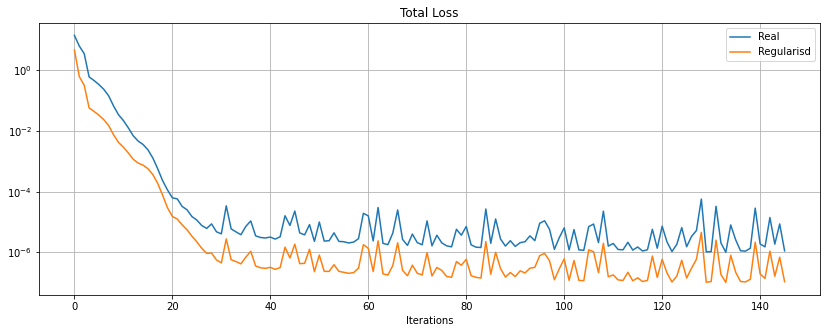

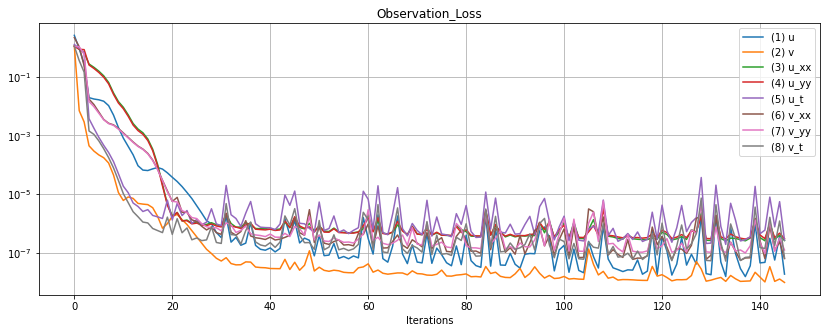

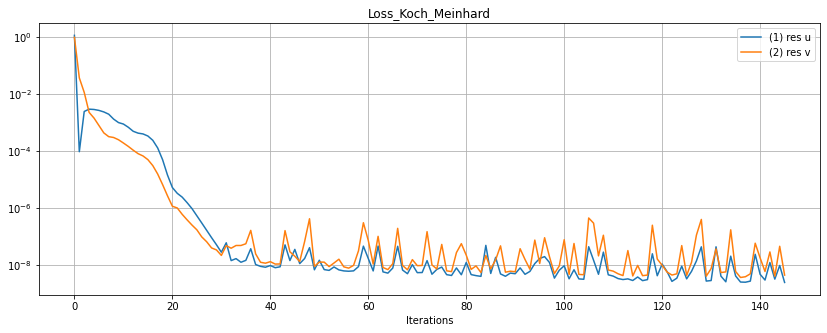

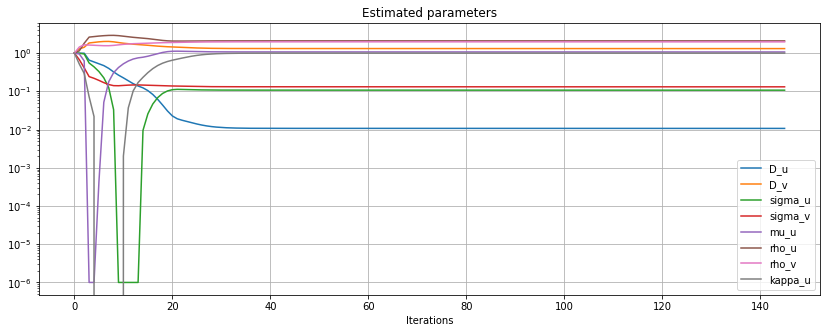

In [60]:
plot_result(merge_dict(results_KM, results_KM2), 
           modelKM, start=0,end=146000 ,skip=1000, param_names=pde_resKM.parameter_names())

In [24]:
modelKM = tu.TINN.restore(".", "patch_points_parameter_estimation_derivatives_outputs_100000", ds_obs)
pinnKM = modelKM.pinn
obs_loss = modelKM.losses[0]
pde_resKM = modelKM.losses[1]

2022-12-19 20:46:19.243793: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-19 20:46:19.748658: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [71]:
def norm_params2(result, simulation):
    D_u = result["D_u"] if "D_u" in result.keys() else simulation.Ds[0]
    D_v = result["D_v"] if "D_v" in result.keys() else simulation.Ds[1]
    sigma_u = result["sigma_u"] if "sigma_u" in result.keys() else simulation.parameters["sigma_u"]
    sigma_v =  result["sigma_v"] if "sigma_v" in result.keys() else simulation.parameters["sigma_v"]
    mu_u = result["mu_u"] if "mu_u" in result.keys() else simulation.parameters["mu_u"]
    rho_u = result["rho_u"] if "rho_u" in result.keys() else simulation.parameters["rho_u"]
    rho_v = result["rho_v"] if "rho_v" in result.keys() else simulation.parameters["rho_v"]
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else simulation.parameters["kappa_u"]
    
    D_u2 = simulation.Ds[0]
    D_v2 = simulation.Ds[1]
    sigma_u2 = simulation.parameters["sigma_u"]
    sigma_v2 = simulation.parameters["sigma_v"]
    mu_u2 = simulation.parameters["mu_u"]
    rho_u2 = simulation.parameters["rho_u"]
    rho_v2 = simulation.parameters["rho_v"]
    kappa_u2 = simulation.parameters["kappa_u"]
    
    return ((D_u-D_u2)**2 + 
            (D_v-D_v2)**2 +
            (sigma_u-sigma_u2)**2 + 
            (sigma_v-sigma_v2)**2 +
            (mu_u-mu_u2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )
        

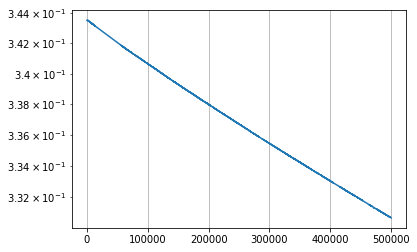

In [73]:
plt.plot(norm_params2(merge_dict(results_KM3), 
             simulation))
plt.yscale('log')
#plt.ylim([0.33, .4])
plt.grid()
plt.show()

In [53]:
test_d = obs_X[:,:3].astype(np.float32)

In [74]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())
print(np.sqrt(l2.reduce_norm(r).numpy()))

[1.5419978e-09, 2.285396e-09]
[1.5419976e-09 2.2853961e-09]
[3.9268278e-05 4.7805817e-05]


In [75]:
outputs =  pinnKM.net(test_d)
#u_xx = outputs[:,0]
#u,  u_xx = (outputs[:,0], outputs[:,1])
#u, v, u_xx = (outputs[:,0], outputs[:,1], outputs[:,2])
#u, v, u_xx, v_xx = (outputs[:,0], outputs[:,1], outputs[:,2], outputs[:,3])
u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (outputs[:,0], outputs[:,1], outputs[:,2],
                                         outputs[:,3], outputs[:,4], outputs[:,5],
                                         outputs[:,6], outputs[:,7])

u1 = u.numpy()[:block_size].reshape(block_x, block_y).T
u2 = u.numpy()[block_size:].reshape(block_x, block_y).T

v1 = v.numpy()[:block_size].reshape(block_x, block_y).T
v2 = v.numpy()[block_size:].reshape(block_x, block_y).T

u_xx1 = u_xx.numpy()[:block_size].reshape(block_x, block_y).T
u_xx2 = u_xx.numpy()[block_size:].reshape(block_x, block_y).T

v_xx1 = v_xx.numpy()[:block_size].reshape(block_x, block_y).T
v_xx2 = v_xx.numpy()[block_size:].reshape(block_x, block_y).T


u_yy1 = u_yy.numpy()[:block_size].reshape(block_x, block_y).T
u_yy2 = u_yy.numpy()[block_size:].reshape(block_x, block_y).T

v_yy1 = v_yy.numpy()[:block_size].reshape(block_x, block_y).T
v_yy2 = v_yy.numpy()[block_size:].reshape(block_x, block_y).T

u_t1 = u_t.numpy()[:block_size].reshape(block_x, block_y).T
u_t2 = u_t.numpy()[block_size:].reshape(block_x, block_y).T

v_t1 = v_t.numpy()[:block_size].reshape(block_x, block_y).T
v_t2 = v_t.numpy()[block_size:].reshape(block_x, block_y).T

In [76]:
der_u_outputs.shape

(32, 3)

In [77]:
print(np.sqrt(np.mean((u_xx1-der_u_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_yy1-der_u_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_t1-der_u_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_xx1-der_v_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_yy1-der_v_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_t1-der_v_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))

0.00010107428451204516
0.00011537944439021554
0.0001657405055143887
0.00010142214119797721
6.898317542199706e-05
0.000143374029233199


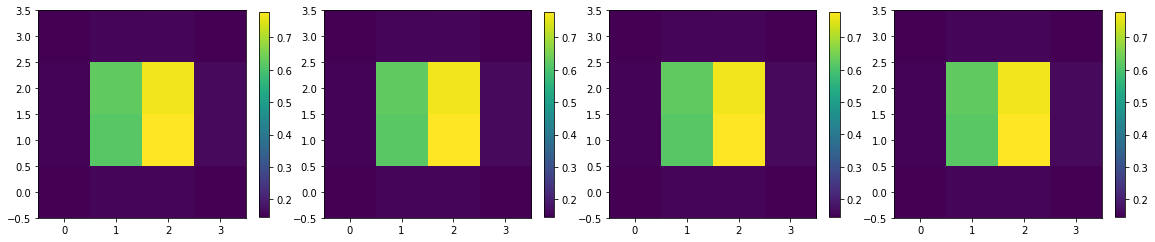

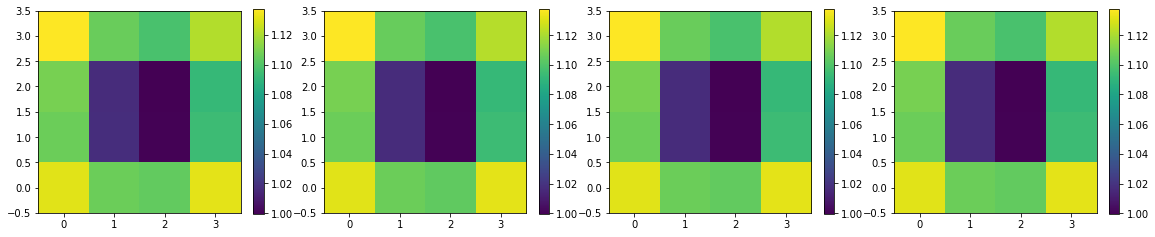

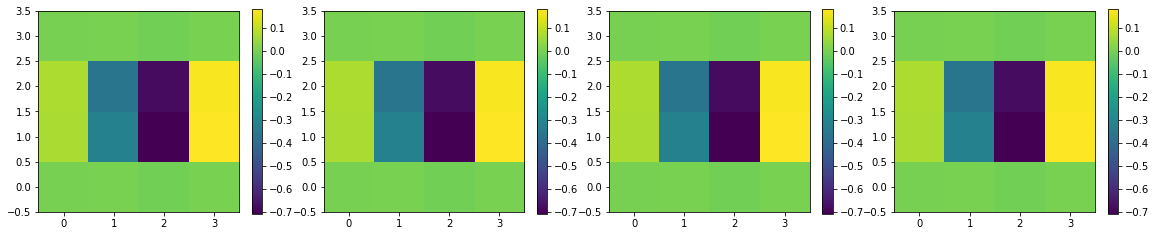

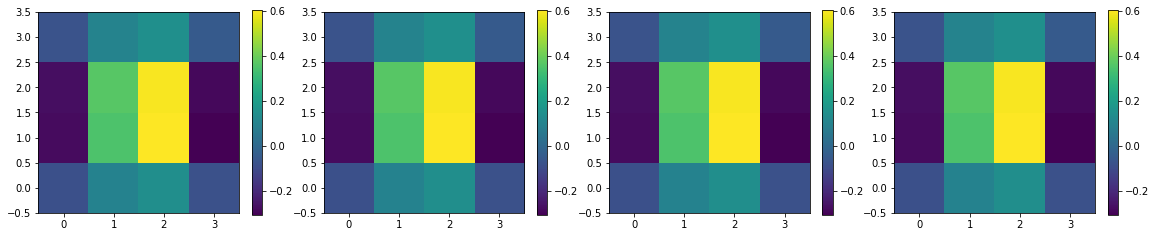

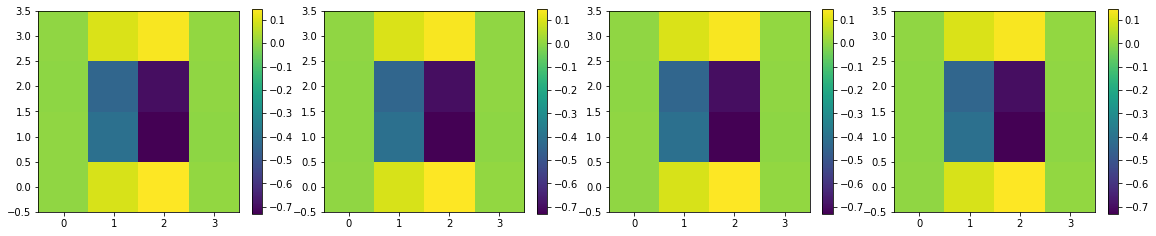

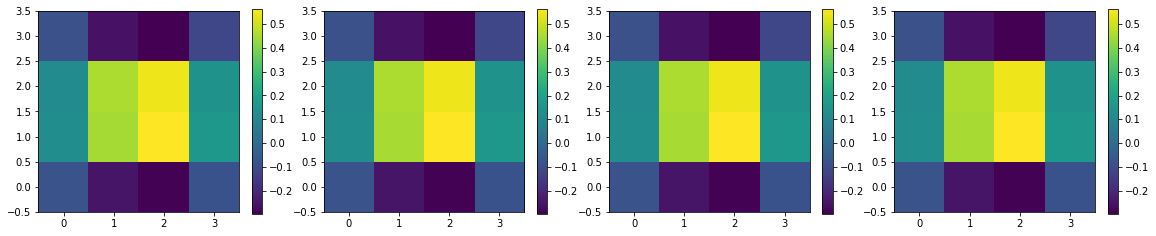

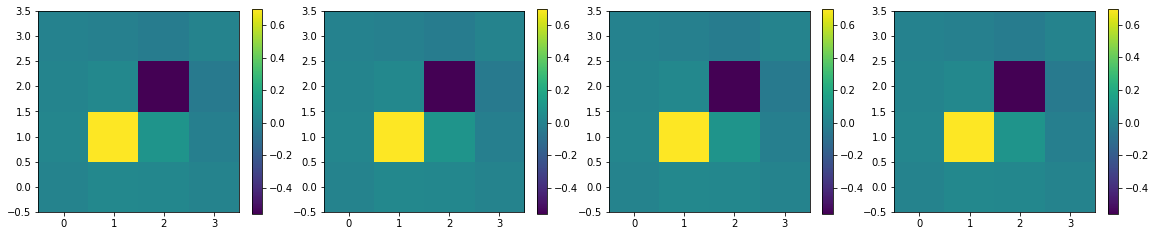

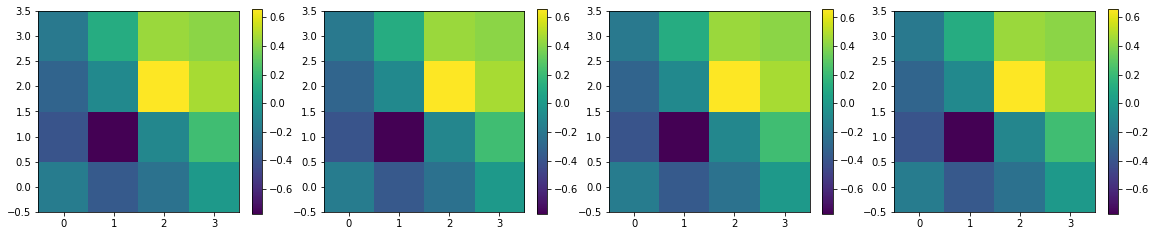

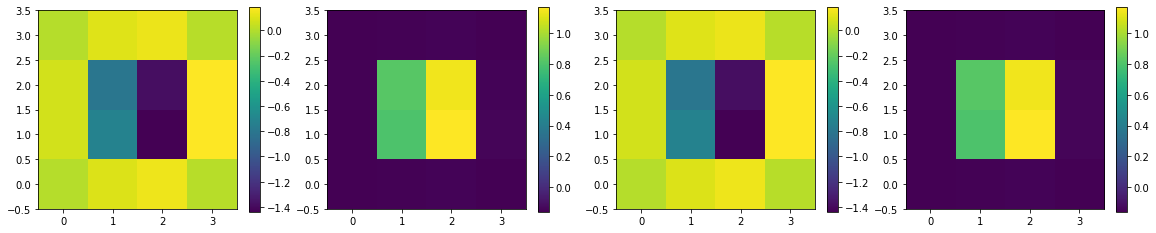

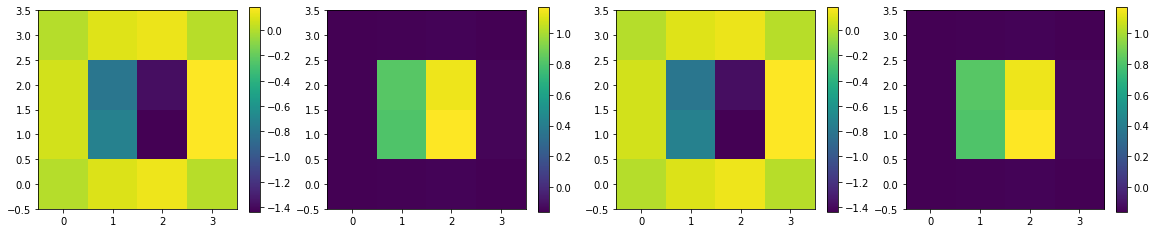

In [78]:
def p(m1, m2,  m3, m4):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(141)
    plt.imshow(m1,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.imshow(m2,
               origin='lower')
    plt.colorbar(shrink=.5)

    plt.subplot(143)
    plt.imshow(m3.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.imshow(m4.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()
p(u1, u2, obs_outputs[:block_size,0], obs_outputs[block_size:,0])
p(v1, v2, obs_outputs[:block_size,1], obs_outputs[block_size:,1])
p(u_xx1, u_xx2, der_u_outputs[:block_size,0], der_u_outputs[block_size:,0])
p(v_xx1, v_xx2, der_v_outputs[:block_size,0], der_v_outputs[block_size:,0])
p(u_yy1, u_yy2, der_u_outputs[:block_size,1], der_u_outputs[block_size:,1])
p(v_yy1, v_yy2, der_v_outputs[:block_size,1], der_v_outputs[block_size:,1])
p(u_t1, u_t2, der_u_outputs[:block_size,2], der_u_outputs[block_size:,2])
p(v_t1, v_t2, der_v_outputs[:block_size,2], der_v_outputs[block_size:,2])

p(u_xx1+u_yy1, (v_xx1+v_yy1), dataset['diff_output'][:block_size,0], dataset['diff_output'][:block_size,1])
p(u_xx2+u_yy2, (v_xx2+v_yy2), dataset['diff_output'][block_size:,0], dataset['diff_output'][block_size:,1])

In [79]:
from scipy.optimize import lsq_linear
from scipy import linalg

In [80]:
params = np.array([simulation.Ds[0], 
                   simulation.parameters["rho_u"],
                   simulation.parameters["mu_u"],
                   simulation.parameters["sigma_u"],
                   simulation.Ds[1], 
                   simulation.parameters["rho_v"],
                   simulation.parameters["sigma_v"]])                   

In [81]:
params2 = np.array([pde_resKM.D_u.get_value(0).numpy()[0],
                    pde_resKM.rho_u.get_value(0).numpy()[0], 
                    pde_resKM.mu_u.get_value(0).numpy()[0], 
                    pde_resKM.sigma_u.get_value(0).numpy()[0],
                    pde_resKM.D_v.get_value(0).numpy()[0],
                    pde_resKM.rho_v.get_value(0).numpy()[0], 
                    pde_resKM.sigma_v.get_value(0).numpy()[0]])

In [97]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = (u_xx.numpy() + u_yy.numpy()).flatten()*4
vxxyy_sol = (v_xx.numpy() + v_yy.numpy()).flatten()*.4

A_sol_1 = np.c_[uxxyy_sol, f_sol, -u_sol , [1]*n2]

A_sol_2 = np.c_[vxxyy_sol, -f_sol , [1]*n2]


u_dt_sol = (u_t.numpy()/1000).flatten()
v_dt_sol = (v_t.numpy()/10000).flatten()

b_sol_1 = -u_dt_sol
b_sol_2 = -v_dt_sol

In [98]:
print(np.sqrt(np.mean(((np.dot(A_sol_1, params[:4])+b_sol_1))**2)))
print(np.sqrt(np.mean(((np.dot(A_sol_1, params2[:4])+b_sol_1))**2)))
print()
print(np.sqrt(np.mean(((np.dot(A_sol_2, params[4:])+b_sol_2))**2)))
print(np.sqrt(np.mean(((np.dot(A_sol_2, params2[4:])+b_sol_2))**2)))

5.035169316898747e-05
3.926540857658664e-05

4.699026991581483e-05
4.781058995603578e-05


In [112]:
params3 = linalg.solve(np.dot(A_sol_1.T,A_sol_1), -np.dot(A_sol_1.T,b_sol_1))
print(params3)
params4 = linalg.solve(np.dot(A_sol_2.T,A_sol_2), -1.42*np.dot(A_sol_2.T,b_sol_2))
print(params4)

[0.01007416 1.96414125 1.00743165 0.10077825]
[1.00045721 1.50041527 0.10001321]


In [114]:
print(np.dot(A_sol_2.T,b_sol_2))
print(1.42*np.dot(A_sol_2.T,b_sol_2))

[ 5.39681930e-06 -8.32825992e-06  7.06788412e-05]
[ 7.66348341e-06 -1.18261291e-05  1.00363954e-04]


In [105]:
np.dot(A_sol_2.T,A_sol_2)

array([[ 1.36553024, -1.02122283,  1.66074155],
       [-1.02122283,  0.89694474, -3.24045211],
       [ 1.66074155, -3.24045211, 32.        ]])

In [95]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = (u_xx.numpy() + u_yy.numpy()).flatten()*4
vxxyy_sol = (v_xx.numpy() + v_yy.numpy()).flatten()*.4

A_sol = np.vstack((np.c_[f_sol,  [0]*n2,  [0]*n2],
                   np.c_[[0]*n2,  vxxyy_sol, -f_sol]))


u_dt_sol = (u_t.numpy()/1000).flatten()
v_dt_sol = (v_t.numpy()/10000).flatten()

b_sol = np.r_[(uxxyy_sol-u_dt_sol-u_sol+1, -v_dt_sol+1)]
#b_sol = np.r_[(uxxyy_sol, vxxyy_sol)]

In [96]:
np.sqrt(np.mean(((np.dot(A_sol, params)+b_sol))**2))

ValueError: shapes (64,3) and (7,) not aligned: 3 (dim 1) != 7 (dim 0)

In [357]:
np.sqrt(np.mean(((np.dot(A_sol, params2)+b_sol))**2))

8.206002896477086e-05

In [358]:
params3 = linalg.solve(np.dot(A_sol.T,A_sol), -np.dot(A_sol.T,b_sol))
params3

array([1.95058623e-02, 9.77675650e+01, 1.47502555e-02])

In [359]:
np.sqrt(np.mean(((np.dot(A_sol, params3)+b_sol))**2))

4.9839658476115134e-05

In [360]:
params2

array([1.9505853e-02, 9.7756248e+01, 1.4748963e-02], dtype=float32)

In [279]:
kappa_u

0.010000000000000002

In [82]:
np.max(u_actual)-np.min(u_actual)

6.341826562258701

In [208]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [248]:
np.sqrt(0.00097)/np.sqrt(np.max(der_v_outputs[:test_size, 0]**2 ))

0.12872605200828996

In [249]:
np.sqrt(0.00097)/np.sqrt(np.mean(der_v_outputs[:test_size, 0]**2 ))

0.2637518238175379

In [241]:
np.max(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) - np.min(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) 

0.5324497151440455

In [282]:
test_size = 32
u_actual = u.numpy().flatten()
v_actual = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (u_xx.numpy() + u_yy.numpy()).flatten()

#(v_xx.numpy() + v_yy.numpy()).flatten()/10
vxxyy_actual = (der_v_outputs[:test_size, 0] + #np.random.normal(0, .05, test_size)+
                der_v_outputs[:test_size, 1]).flatten()/10
vxxyy_actual = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (u_t.numpy()/100).flatten()
v_dt_actual = (v_t.numpy()/1000).flatten()

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [283]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.96889015e-02, 6.07703016e+01, 1.06397409e-02])

In [172]:
test_size = 32
u_actual = obs_outputs[:test_size, 0]
v_actual = obs_outputs[:test_size, 1]

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])
vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (der_u_outputs[:test_size, 2] /100)
v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [173]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.97328100e-02, 9.94934181e+01, 1.51207473e-02])

In [284]:
def add_noise(noise_level = 0, kappa_sol = None):
    test_size = 33
    u_actual = obs_outputs[:test_size, 0].copy() 
    v_actual = obs_outputs[:test_size, 1].copy()    
    test_size = len(u_actual)
    
    if kappa_sol is None:
        kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

    f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


    uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])    
    
    
    if noise_level > 0:
        v_xx_band = np.max(der_v_outputs[:test_size, 0])-np.min(der_v_outputs[:test_size, 0])
        v_yy_band = np.max(der_v_outputs[:test_size, 1])-np.min(der_v_outputs[:test_size, 1])
        vxx_actual = der_v_outputs[:test_size, 0] + np.random.normal(0, v_xx_band*noise_level , test_size)
        vyy_actual = der_v_outputs[:test_size, 1] + np.random.normal(0, v_yy_band*noise_level , test_size)
        vxxyy_actual =(vxx_actual + vyy_actual).flatten()/10        
    else:
        vxx_actual = der_v_outputs[:test_size, 0]
        vyy_actual = der_v_outputs[:test_size, 1]
        vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

    A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                          np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


    u_dt_actual = (der_u_outputs[:test_size, 2] /100)
    v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

    b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]
    params_pred = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
    
    v_xx_err = np.mean((der_v_outputs[:test_size, 0] - vxx_actual)**2)
    v_yy_err = np.mean((der_v_outputs[:test_size, 1] - vyy_actual)**2)    
    return tuple(params_pred.tolist() )+ (v_xx_err, v_yy_err)
    

In [201]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [285]:
noise_levels = np.linspace(0,.3, 100)
ensumble_n = 100
for n in range(ensumble_n):
    if n == 0:
        estimates = np.array([add_noise(n_l) for n_l in noise_levels])
    else:
        estimates += np.array([add_noise(n_l) for n_l in noise_levels])
        
estimates /= ensumble_n

In [286]:
estimates.shape

(100, 5)

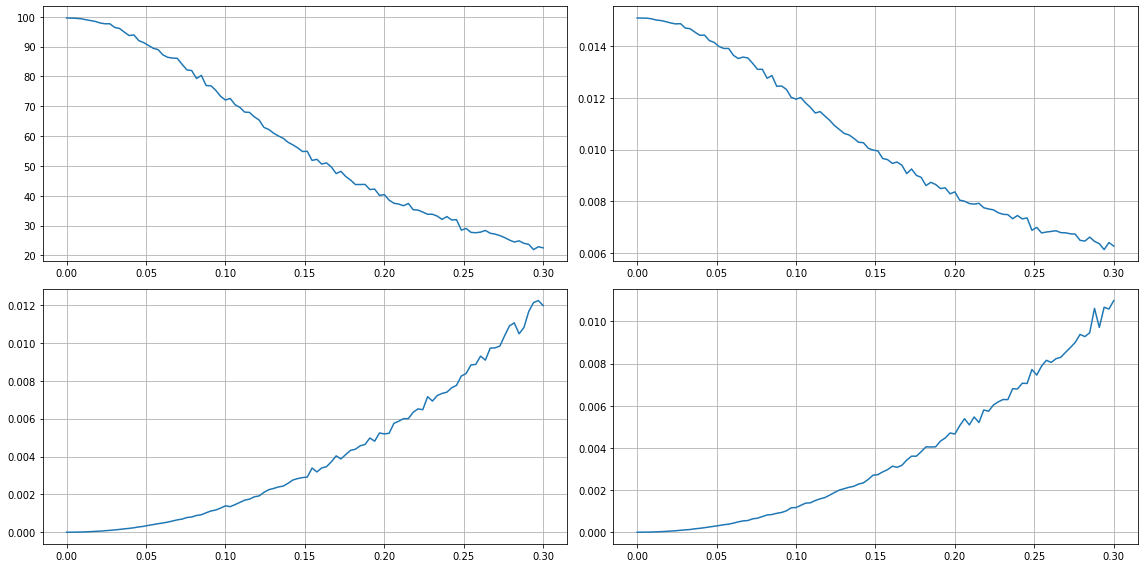

In [287]:
_ = plt.figure(figsize=(16, 8))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,i*2+j+1)
        plt.plot(noise_levels, estimates[:, i*2+j+1])        
        plt.grid()
plt.tight_layout()
plt.show()

In [138]:
add_noise(0)

(0.01973280997722836,
 99.49341812882234,
 0.015120747280319324,
 0.0,
 0.0,
 3.7494859510203646e-06,
 8.287541347416645e-07)

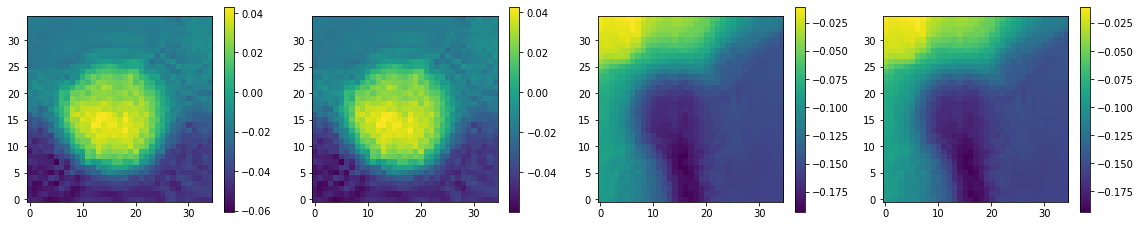

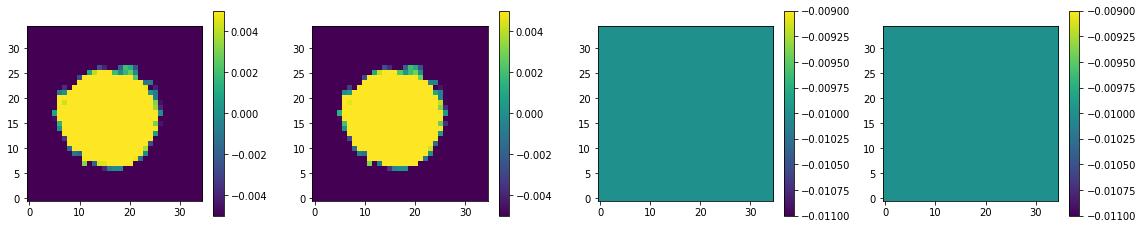

In [56]:
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1,res2,res3,res4)
thres1=0.005
thres2=-0.005
res1[res1 > thres1] = thres1
res1[res1 < thres2] = thres2
res2[res2 > thres1] = thres1
res2[res2 < thres2] = thres2
thres1=0.01
thres2=-0.01
res3[res3 > thres1] = thres1
res3[res3 < thres2] = thres2
res4[res4 > thres1] = thres1
res4[res4 < thres2] = thres2
p(res1,res2,res3,res4)

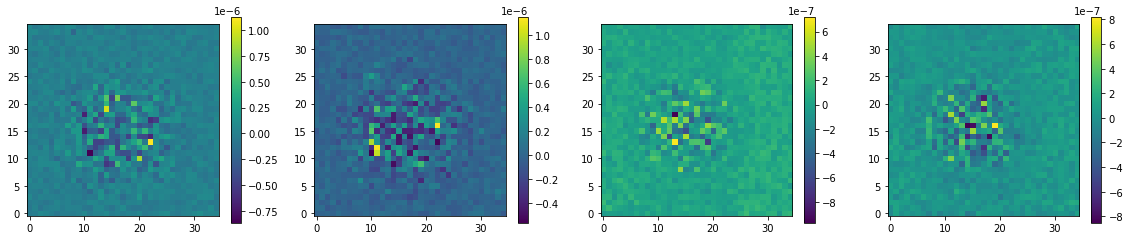

In [57]:
fu_sol, fv_sol = pde_resKM.residual(pinnKM, test_d)
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1+fu_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res2+fu_sol.numpy()[block_size:].reshape(block_x, block_y).T,
  res3+fv_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res4+fv_sol.numpy()[block_size:].reshape(block_x, block_y).T,)

In [61]:
res_obs = lsq_linear(A_sol, b_sol, bounds=(0.0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1, -1, -1])
        cost: 16551.379752990466
         fun: array([ 0.55743337,  0.55322146,  0.55879426, ..., -0.99963897,
       -0.99963588, -0.99964142])
     message: 'The first-order optimality measure is less than `tol`.'
         nit: 13
  optimality: 4.320909614557874e-28
      status: 1
     success: True
           x: array([1.27266364e-46, 2.09048140e-28, 8.46731860e-48])

In [269]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size
u_obs = obs_outputs[:,0].flatten()
v_obs = obs_outputs[:,1].flatten()
f_obs = u_obs * u_obs * v_obs / (1.0 + simulation.parameters['kappa_u'] * u_obs * u_obs)
A_obs = np.vstack((np.c_[f_obs, -u_obs, [1]*n2, [0]*n2, [0]*n2],
                   np.c_[[0]*n2, [0]*n2, [0]*n2, -f_obs, [1]*n2]))

uxxyy_obs =simulation.Ds[0] *  (der_u_outputs[:,0] + der_u_outputs[:,1]).flatten()
vxxyy_obs =simulation.Ds[1] *  (der_v_outputs[:,0] + der_v_outputs[:,1]).flatten()
u_dt = der_u_outputs[:,2].flatten()
v_dt = der_v_outputs[:,2].flatten()

b_obs = np.r_[(uxxyy_obs-u_dt, vxxyy_obs-v_dt)]

In [169]:
np.sqrt(np.mean(((np.dot(A_obs, params)+b_obs))**2))

4.3139633449820096e-07

In [303]:
res_obs = lsq_linear(A_obs, b_obs, bounds=(0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1,  0,  0, -1,  0])
        cost: 55.98322605362867
         fun: array([0.01198398, 0.01190489, 0.01179273, ..., 0.13051092, 0.13049243,
       0.1304939 ])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 9
  optimality: 1.7763568394002505e-14
      status: 2
     success: True
           x: array([2.11852294e-033, 7.28018337e-002, 2.27743983e-002, 4.94065646e-324,
       6.59956339e-002])

In [136]:
b_obs = np.r_[(uxxyy_obs, vxxyy_obs)]

In [160]:
res1=(np.dot(A_obs, params2)+b_obs
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_obs, params2)+b_obs
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_obs, params2)+b_obs
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_obs, params2)+b_obs
     )[3*block_size:].reshape(block_x, block_y).T

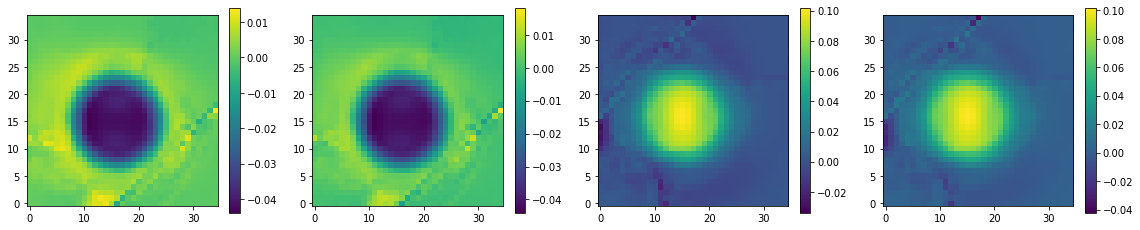

In [161]:
p(res1,res2,res3,res4)

In [380]:
import rdsolver

In [403]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 2*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = pde_resKM.sigma_u.get_value(0).numpy()[0]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = pde_resKM.sigma_v.get_value(0).numpy()[0]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -pde_resKM.mu_u.get_value(0).numpy()[0]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (pde_resKM.rho_u.get_value(0).numpy()[0],
          pde_resKM.rho_v.get_value(0).numpy()[0],
          pde_resKM.kappa_u.get_value(0).numpy()[0])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [01:26<00:00,  8.61s/it]


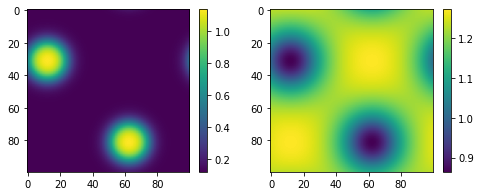

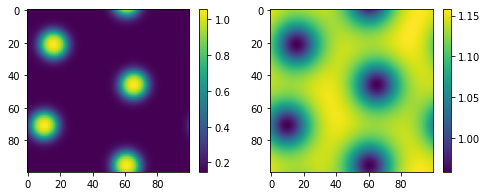

In [406]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [388]:
simulation

Simulation(name='Koch_Meinhardt_9', n=(100, 100), L=(8, 8), Ds=(0.01, 1.0), dt=0.001, t_start=0, t_end=768.0, t_steps=769, dt_arr=None, parameters={'kappa_u': 1.0, 'mu_u': 1.0, 'rho_u': 1.95, 'rho_v': 1.5, 'sigma_u': 0.1, 'sigma_v': 0.1}, steady_state_func=None, perturbation_size=0.1, kinetic_func=None, tol=0.001, sample_parameters=True, sample_parameters_num=10, sample_parameters_std=(0.0, 0.01, 0.01, 0.01, 0.001, 0.001), same_init=True, c0=None)

In [421]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 4*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = 4*simulation.parameters["sigma_u"]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = simulation.parameters["sigma_v"]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -4*simulation.parameters["mu_u"]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (4*simulation.parameters["rho_u"],
          simulation.parameters["rho_v"],
          simulation.parameters["kappa_u"])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [02:05<00:00, 12.55s/it]


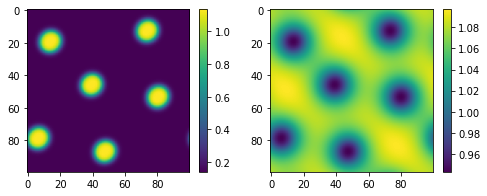

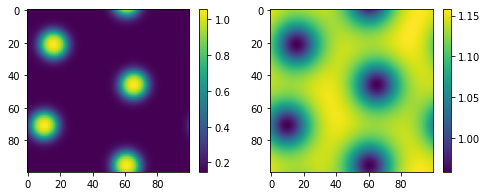

In [422]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [407]:
print(pde_resKM.trainables_str())

sigma_u: 0.03358 sigma_v: 0.08917 mu_u: 0.38960 rho_u: 0.74692 
rho_v: 1.29434 kappa_u: 0.75477 


In [408]:
simulation.parameters

{'kappa_u': 1.0,
 'mu_u': 1.0,
 'rho_u': 1.95,
 'rho_v': 1.5,
 'sigma_u': 0.1,
 'sigma_v': 0.1}

In [412]:
(1/0.38960)#*0.03358

2.566735112936345

In [414]:
2.5*0.74692 

1.8673000000000002

In [268]:
minimize_parameters(pde_resKM, pinnKM, test_d, [pde_resKM.rho_u, pde_resKM.rho_v, pde_resKM.kappa_u], 
                    method="Nelder-Mead", tol=1e-9 )

 final_simplex: (array([[0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ]]), array([4.10391617, 4.10391617, 4.10391617, 4.10391617]))
           fun: 4.103916168212891
       message: 'Optimization terminated successfully.'
          nfev: 231
           nit: 119
        status: 0
       success: True
             x: array([0.02013884, 0.06914701, 0.0114    ])

In [62]:
import copy

In [81]:

pde_resKM2 = copy.deepcopy(pde_resKM) 

In [82]:

@tf.function
def resi4(v1, v2):
    pde_resKM2.D.set_value(v1)
    pde_resKM2.rho_v.set_value(v2)
    return pde_resKM2.residual(pinnKM, test_d)   

In [156]:
D_range = np.linspace(40, 80, 30)
rho_v_range = np.linspace(.01, .012, 30)

D_mesh, rho_v_mesh = np.meshgrid(D_range, rho_v_range)

In [157]:
v_res = np.zeros_like(rho_v_mesh)
l2_norm = L2()
for i, _ in enumerate(D_mesh):    
    
    for j, _ in enumerate(rho_v_mesh):
        v1 = D_mesh[i,j]
        v2 = rho_v_mesh[i,j]        
        
        test_pde_u, test_pde_v = resi4(v1.astype(np.float32), v2.astype(np.float32))        
        
        v_res[i,j] = l2_norm.reduce_norm((test_pde_v,)).numpy()[0]
        

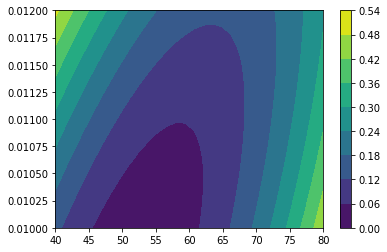

In [159]:
#_ = plt.figure(figsize=(16,4))

plt.contourf(D_range, rho_v_range, v_res)
#plt.imshow(v_res)
plt.colorbar()

plt.show()


In [160]:
print(pde_resKM.trainables_str())

D: 52.67937 rho_u: 0.02041 rho_v: 0.00995 kappa_u: 0.01109 



In [161]:
pde_resKM.outputs_correction_fact

ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.01>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.001>])

In [167]:
@tf.function
def resi2():
    outputs = pinnKM.net(test_d)
    u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (
        outputs[:, 0] * pde_resKM.outputs_correction_fact[0],
        outputs[:, 1] * pde_resKM.outputs_correction_fact[1],
        outputs[:, 2] * pde_resKM.outputs_correction_fact[2],
        outputs[:, 3] * pde_resKM.outputs_correction_fact[3],
        outputs[:, 4] * pde_resKM.outputs_correction_fact[4],
        outputs[:, 5] * pde_resKM.outputs_correction_fact[5],
        outputs[:, 6] * pde_resKM.outputs_correction_fact[6],
        outputs[:, 7] * pde_resKM.outputs_correction_fact[7],
    )
    D = pde_resKM.D.get_value(0)        
    rho_v = pde_resKM.rho_v.get_value(0)
    kappa_u = pde_resKM.kappa_u.get_value(0)
    f = u * u * v / (1.0 + kappa_u * u * u)
    return (v_t - 1, v_xx + v_yy, f)

In [168]:
kappa_u

0.010000000000000002

In [169]:

#pde_resKM.kappa_u.set_value(0.01136 )
pde_resKM.kappa_u.set_value(kappa_u)
a, d, b = resi2()

In [165]:

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)
A_sol =  f_sol

vxxyy_sol = D * (v_xx.numpy() + v_yy.numpy()).flatten()/10
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = v_dt_sol-vxxyy_sol-1

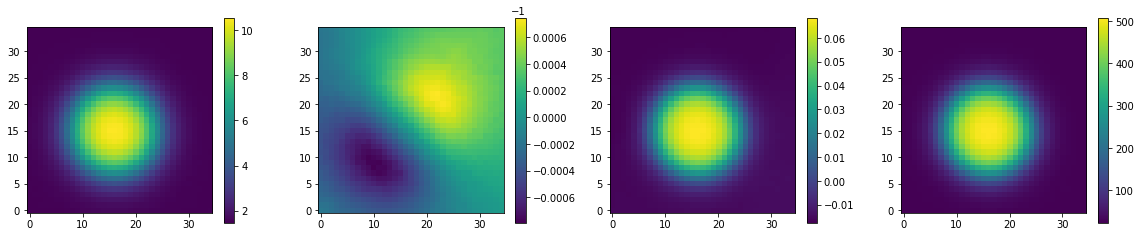

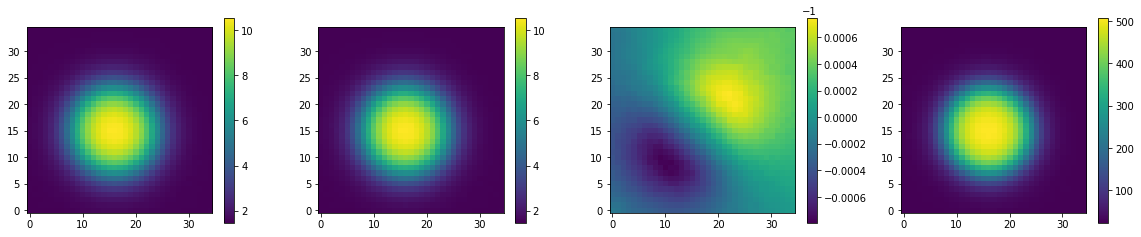

In [171]:
p(u1,  a.numpy()[:block_size].reshape(block_x, block_y).T,d.numpy()[:block_size], b.numpy()[:block_size])
p(u1, u2, a.numpy()[block_size:], b.numpy()[block_size:])
#p(u1, u2, a.numpy()[:block_size]/b.numpy()[:block_size], a.numpy()[block_size:]/b.numpy()[block_size:])
#p(u1, u2, b_sol[block_size:], A_sol[block_size:] )

In [102]:
A_sol[2*block_size:, 1].shape

(2450,)

In [104]:
b_sol[2*block_size:].shape

(2450,)